# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = data[data['income'] == '>50K'].shape[0]

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = data[data['income'] == '<=50K'].shape[0]

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k / (n_greater_50k + n_at_most_50k)) * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

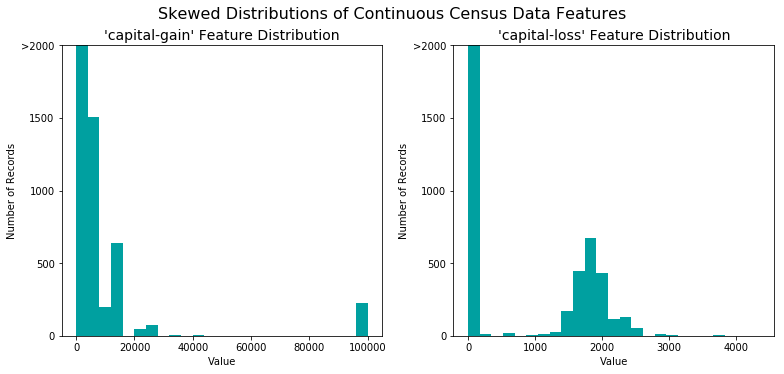

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

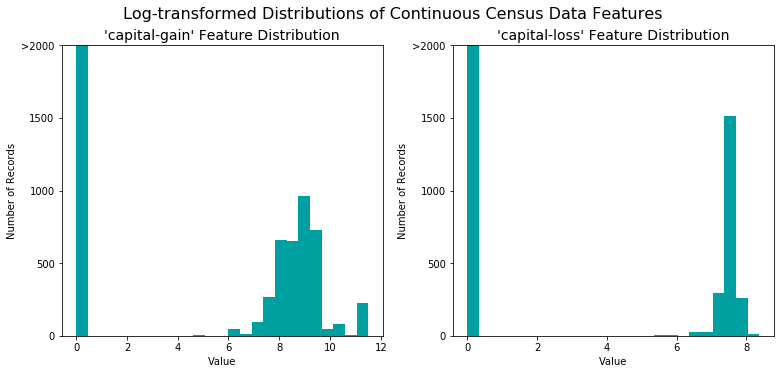

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|  .  | someFeature |
|-----|-------------|                    
| 0   |  B          |                    
| 1   |  C          |   
| 2   |  A          |


### `one-hot encode ---->`
| someFeature_A | someFeature_B | someFeature_C |
|---------------|---------------|---------------|
| 0             | 1             | 0             |
| 0             | 0             | 1             |
| 1             | 0             | 0             |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = np.where(income_raw.str.match("<=50K"),0,1)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
#print(encoded)

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \\$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \\$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [8]:
# Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' 
# data encoded to numerical values done in the data preprocessing step.
TP = np.sum(income)
# Specific to the naive case
FP = income.size - TP

# No predicted negatives in the naive case
TN = 0
FN = 0

# TODO: Calculate accuracy, precision and recall
accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1 + beta**2) * ( (precision*recall) / ((beta**2 * precision) + recall) )

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

# `*FINISH CITATIONS*`
**Answer:**

### Gradient Boosting

- Gradient Boosting has been used in Machine-Learned Rank. A real-world application of this is Yahoo's search engine which used variants of gradient boosting in their machine-learned ranking engines.

- Its strengths lie in it's ability to heterogeneous datasets, its predictive power, and its robustness to outliers in output space.

- Its weaknesses are the ability to scale. Wit large datasets, it would be difficult to parallelize given that boosting needs to be done in sequential order.

- Gradient Boosting is a good candidate given that "ensemble methods are high quality classifier." We have a heterogeneous dataset, which Gradient Boosting is robust to.

### K-Nearest Neighbors

- K-Nearest Neighbors has been used in real-world classification and regression problems, such as classifying handwritten digits and satellite image scenes.

- Its strength lie in large training data, and its ability to properly handle noisy training data.

- Its weaknesses are in computation cost since it needs to compute the distance of all training samples.

- K-Nearest Neighboors is a good candidate given that it is able to handle a large training set, as well as it not being text data.

### Gaussian Naive Bayes
- Naive Bayes Classifiers has been use in real-world document classification problems and with email spam filtering. [1]

- Its strength lies in that it only requires a small amount of training data. [2]

- One of its major weaknesses is that its probability estimation is bad, so within scikit-learn, one should not rely on the results returned by `predict_proba`. [1][3]

- Gaussian Naive Bayes is a good candidate for this problem given that it meets the proper criteria listed in scikit-learn's guide on choosing the right estimator. The data is labled, it has less than 100K data samples, and we have text data. [4]

>[1] https://scikit-learn.org/stable/modules/naive_bayes.html <br>
>[2] https://en.wikipedia.org/wiki/Naive_Bayes_classifier <br>
>[3] http://www.cs.unb.ca/~hzhang/publications/FLAIRS04ZhangH.pdf <br>
>[4] https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html <br>

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' 
    # using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # beta score for both f_train and f_test
    beta = 0.5
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
   
    #print("-----------------")
    #print("f_train: %s" % results['f_train'])
    #print("f_test: %s" % results['f_test'])
    #print("-----------------\n")
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

GradientBoostingClassifier trained on 361 samples.


/home/lazyhacker/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.
KNeighborsClassifier trained on 361 samples.
KNeighborsClassifier trained on 3617 samples.
KNeighborsClassifier trained on 36177 samples.
GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.


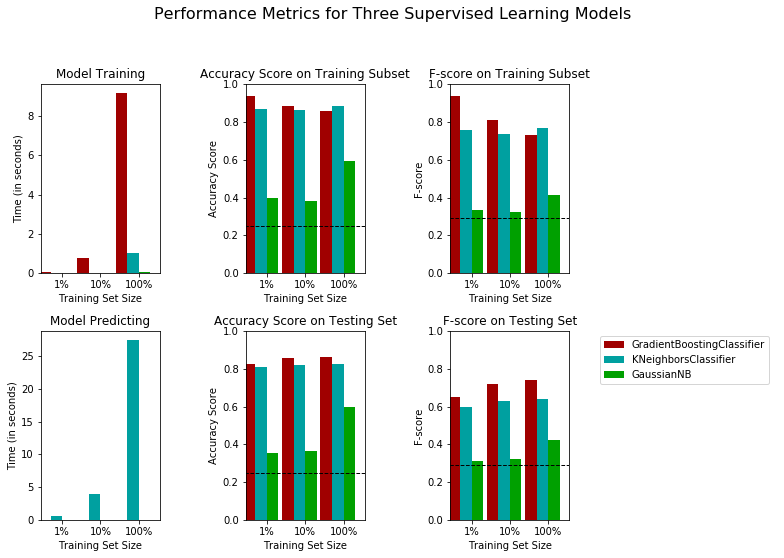

In [10]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# TODO: Initialize the three models
clf_A = GradientBoostingClassifier(random_state=0)
clf_B = KNeighborsClassifier()
clf_C = GaussianNB()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(len(y_train) * 0.1)
samples_1 = int(len(y_train) * 0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [11]:
for i in results.items():
    display(i[0])
    display(pd.DataFrame(i[1])[[2]].rename(columns={2:'100%'}))
    print()

'GradientBoostingClassifier'

,100%
acc_test,0.863018
acc_train,0.856667
f_test,0.739534
f_train,0.734127
pred_time,0.023800
train_time,9.148892


'KNeighborsClassifier'

,100%
acc_test,0.823549
acc_train,0.883333
f_test,0.639164
f_train,0.771605
pred_time,27.456255
train_time,1.019078


'GaussianNB'

,100%
acc_test,0.597678
acc_train,0.593333
f_test,0.420899
f_train,0.412500
pred_time,0.014045
train_time,0.059856


----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model [## FINISH ANSWER]

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer:**

Based on evaluating the three models, the one which did the best when using 100% of the testing set was the GradientBoostingClassifier. With the GradientBoostingClassifier I was able to get an f-score of `0.7341269841269841` on the training set, and an f-score of `0.7395338561802719` on the testing set.

There is an upfront cost with training time, but once we have our model, prediction takes very little time. This would be ideal for the task that CharityML is targeting since we would do all the heavy lifting upfront, then we can make reasonably accurate predictions with all new future data.

Gradient Boosting is suitable for this problem given that it can handle heterogeneous data.

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

**Answer:**



### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [12]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = GradientBoostingClassifier(learning_rate=0.005,max_features=11,max_depth=7,min_samples_split=920,min_samples_leaf=25,subsample=0.80,random_state=0,verbose=2)

# Create the parameters list you wish to tune.
parameters = {'n_estimators':[7600]} #'n_estimators':[370,380,390],'max_depth':5, 'min_samples_split':3600, 'min_samples_leaf':100, 'max_features':4}

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)
print(best_clf)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1198           0.0031            3.32m
         2           1.1093           0.0037            3.37m
         3           1.1085           0.0029            3.46m


/home/lazyhacker/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/lazyhacker/anaconda3/lib/python3.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


         4           1.1052           0.0036            3.50m
         5           1.1113           0.0035            3.56m
         6           1.1024           0.0032            3.51m
         7           1.1000           0.0028            3.50m
         8           1.0951           0.0030            3.46m
         9           1.0916           0.0031            3.48m
        10           1.0902           0.0035            3.46m
        11           1.0864           0.0026            3.49m
        12           1.0856           0.0032            3.52m
        13           1.0785           0.0032            3.51m
        14           1.0759           0.0030            3.52m
        15           1.0762           0.0028            3.54m
        16           1.0724           0.0023            3.52m
        17           1.0659           0.0029            3.53m
        18           1.0667           0.0024            3.53m
        19           1.0599           0.0030            3.56m
        

       142           0.8452           0.0011            3.53m
       143           0.8462           0.0012            3.53m
       144           0.8414           0.0011            3.53m
       145           0.8416           0.0011            3.53m
       146           0.8409           0.0012            3.53m
       147           0.8400           0.0013            3.53m
       148           0.8412           0.0012            3.53m
       149           0.8358           0.0011            3.53m
       150           0.8395           0.0011            3.53m
       151           0.8358           0.0011            3.53m
       152           0.8324           0.0011            3.53m
       153           0.8331           0.0009            3.53m
       154           0.8316           0.0009            3.52m
       155           0.8339           0.0010            3.52m
       156           0.8311           0.0011            3.52m
       157           0.8287           0.0009            3.52m
       1

       279           0.7381           0.0005            3.38m
       280           0.7387           0.0008            3.38m
       281           0.7362           0.0005            3.38m
       282           0.7347           0.0006            3.37m
       283           0.7372           0.0005            3.37m
       284           0.7381           0.0006            3.37m
       285           0.7320           0.0006            3.37m
       286           0.7365           0.0006            3.37m
       287           0.7350           0.0002            3.36m
       288           0.7358           0.0005            3.36m
       289           0.7344           0.0006            3.36m
       290           0.7371           0.0004            3.36m
       291           0.7343           0.0004            3.36m
       292           0.7254           0.0005            3.35m
       293           0.7262           0.0004            3.35m
       294           0.7300           0.0006            3.35m
       2

       413           0.6849           0.0002            3.25m
       414           0.6821           0.0003            3.25m
       415           0.6795           0.0002            3.25m
       416           0.6821           0.0003            3.25m
       417           0.6838           0.0003            3.25m
       418           0.6817           0.0003            3.24m
       419           0.6864           0.0003            3.24m
       420           0.6836           0.0003            3.24m
       421           0.6803           0.0003            3.24m
       422           0.6844           0.0003            3.24m
       423           0.6844           0.0002            3.24m
       424           0.6804           0.0003            3.24m
       425           0.6792           0.0002            3.24m
       426           0.6769           0.0003            3.24m
       427           0.6817           0.0003            3.24m
       428           0.6802           0.0003            3.24m
       4

       546           0.6549           0.0002            3.15m
       547           0.6523           0.0002            3.15m
       548           0.6535           0.0002            3.15m
       549           0.6526           0.0001            3.15m
       550           0.6524           0.0002            3.15m
       551           0.6543           0.0002            3.15m
       552           0.6532           0.0001            3.15m
       553           0.6522           0.0001            3.15m
       554           0.6494           0.0002            3.15m
       555           0.6519           0.0002            3.15m
       556           0.6536           0.0001            3.15m
       557           0.6536           0.0002            3.15m
       558           0.6523           0.0002            3.14m
       559           0.6544           0.0002            3.14m
       560           0.6508           0.0002            3.14m
       561           0.6471           0.0001            3.14m
       5

       683           0.6353           0.0001            3.05m
       684           0.6359           0.0001            3.05m
       685           0.6345           0.0001            3.05m
       686           0.6302           0.0001            3.05m
       687           0.6345           0.0001            3.05m
       688           0.6309           0.0001            3.05m
       689           0.6319           0.0001            3.05m
       690           0.6313           0.0001            3.05m
       691           0.6309           0.0001            3.04m
       692           0.6329           0.0001            3.04m
       693           0.6315           0.0001            3.04m
       694           0.6322           0.0001            3.04m
       695           0.6310           0.0001            3.04m
       696           0.6294           0.0001            3.04m
       697           0.6354           0.0001            3.04m
       698           0.6329           0.0001            3.04m
       6

       816           0.6204           0.0001            2.95m
       817           0.6202           0.0001            2.95m
       818           0.6175           0.0001            2.95m
       819           0.6140           0.0000            2.95m
       820           0.6163           0.0001            2.95m
       821           0.6122           0.0000            2.95m
       822           0.6152           0.0001            2.94m
       823           0.6188           0.0001            2.94m
       824           0.6188           0.0000            2.94m
       825           0.6214           0.0001            2.94m
       826           0.6203           0.0001            2.94m
       827           0.6159           0.0001            2.94m
       828           0.6146           0.0001            2.94m
       829           0.6235           0.0000            2.94m
       830           0.6196           0.0000            2.94m
       831           0.6148           0.0001            2.94m
       8

       953           0.6027           0.0000            2.85m
       954           0.6079           0.0000            2.85m
       955           0.6110           0.0001            2.85m
       956           0.6081           0.0001            2.85m
       957           0.6054           0.0001            2.85m
       958           0.6100           0.0001            2.85m
       959           0.6066           0.0001            2.85m
       960           0.6035           0.0000            2.85m
       961           0.6061           0.0000            2.85m
       962           0.6089           0.0000            2.85m
       963           0.6106           0.0001            2.85m
       964           0.6057           0.0001            2.85m
       965           0.6081           0.0000            2.84m
       966           0.6058           0.0000            2.84m
       967           0.6095           0.0000            2.84m
       968           0.6058           0.0000            2.84m
       9

      1093           0.5997           0.0000            2.76m
      1094           0.6000           0.0000            2.76m
      1095           0.5980           0.0000            2.76m
      1096           0.6057           0.0000            2.76m
      1097           0.6031           0.0000            2.75m
      1098           0.6080           0.0000            2.75m
      1099           0.5991           0.0000            2.75m
      1100           0.6002           0.0000            2.75m
      1101           0.6044           0.0001            2.75m
      1102           0.5993           0.0000            2.75m
      1103           0.5987           0.0001            2.75m
      1104           0.6028           0.0000            2.75m
      1105           0.5992           0.0000            2.75m
      1106           0.5925           0.0000            2.75m
      1107           0.5982           0.0000            2.75m
      1108           0.5972           0.0000            2.75m
      11

      1233           0.5957           0.0000            2.67m
      1234           0.5952           0.0000            2.67m
      1235           0.6004           0.0000            2.67m
      1236           0.5946           0.0000            2.67m
      1237           0.5978           0.0000            2.67m
      1238           0.5953          -0.0000            2.67m
      1239           0.5962           0.0000            2.66m
      1240           0.5982           0.0000            2.66m
      1241           0.5972           0.0000            2.66m
      1242           0.5966           0.0000            2.66m
      1243           0.5954          -0.0000            2.66m
      1244           0.5956          -0.0000            2.66m
      1245           0.5931           0.0000            2.66m
      1246           0.5934           0.0000            2.66m
      1247           0.5966           0.0000            2.66m
      1248           0.5961           0.0000            2.66m
      12

      1372           0.5931          -0.0000            2.57m
      1373           0.5976           0.0000            2.57m
      1374           0.5899           0.0000            2.57m
      1375           0.5921           0.0000            2.57m
      1376           0.5891           0.0000            2.57m
      1377           0.5887           0.0000            2.57m
      1378           0.5949           0.0000            2.57m
      1379           0.5940           0.0000            2.57m
      1380           0.5962           0.0000            2.57m
      1381           0.5911           0.0000            2.57m
      1382           0.5911          -0.0000            2.57m
      1383           0.5913           0.0000            2.57m
      1384           0.5880           0.0000            2.57m
      1385           0.5918           0.0000            2.57m
      1386           0.5942           0.0000            2.56m
      1387           0.5922           0.0000            2.56m
      13

      1511           0.5880           0.0000            2.48m
      1512           0.5890          -0.0000            2.48m
      1513           0.5895          -0.0000            2.48m
      1514           0.5782          -0.0000            2.48m
      1515           0.5919           0.0000            2.48m
      1516           0.5886          -0.0000            2.48m
      1517           0.5920           0.0000            2.48m
      1518           0.5838           0.0000            2.48m
      1519           0.5864           0.0000            2.48m
      1520           0.5872          -0.0000            2.48m
      1521           0.5905           0.0000            2.48m
      1522           0.5849           0.0000            2.47m
      1523           0.5818           0.0000            2.47m
      1524           0.5853          -0.0000            2.47m
      1525           0.5834          -0.0000            2.47m
      1526           0.5916          -0.0000            2.47m
      15

      1650           0.5840          -0.0000            2.39m
      1651           0.5871           0.0000            2.38m
      1652           0.5917          -0.0000            2.38m
      1653           0.5839           0.0000            2.38m
      1654           0.5816          -0.0000            2.38m
      1655           0.5832          -0.0000            2.38m
      1656           0.5866           0.0000            2.38m
      1657           0.5811          -0.0000            2.38m
      1658           0.5839          -0.0000            2.38m
      1659           0.5854          -0.0000            2.38m
      1660           0.5796           0.0000            2.38m
      1661           0.5868           0.0000            2.38m
      1662           0.5912           0.0000            2.38m
      1663           0.5775           0.0000            2.38m
      1664           0.5852           0.0000            2.38m
      1665           0.5816          -0.0000            2.38m
      16

      1789           0.5798           0.0000            2.30m
      1790           0.5774           0.0000            2.30m
      1791           0.5837          -0.0000            2.30m
      1792           0.5772           0.0000            2.29m
      1793           0.5777          -0.0000            2.29m
      1794           0.5797           0.0000            2.29m
      1795           0.5814           0.0000            2.29m
      1796           0.5810          -0.0000            2.29m
      1797           0.5813          -0.0000            2.29m
      1798           0.5836           0.0000            2.29m
      1799           0.5847           0.0000            2.29m
      1800           0.5853           0.0000            2.29m
      1801           0.5809           0.0000            2.29m
      1802           0.5804          -0.0000            2.29m
      1803           0.5831          -0.0000            2.29m
      1804           0.5828           0.0000            2.29m
      18

      1927           0.5800           0.0000            2.22m
      1928           0.5772          -0.0000            2.22m
      1929           0.5827           0.0000            2.22m
      1930           0.5809           0.0000            2.22m
      1931           0.5785          -0.0000            2.21m
      1932           0.5858           0.0000            2.21m
      1933           0.5812          -0.0000            2.21m
      1934           0.5763          -0.0000            2.21m
      1935           0.5756          -0.0000            2.21m
      1936           0.5782           0.0000            2.21m
      1937           0.5760          -0.0000            2.21m
      1938           0.5771           0.0000            2.21m
      1939           0.5781          -0.0000            2.21m
      1940           0.5736          -0.0000            2.21m
      1941           0.5784          -0.0000            2.21m
      1942           0.5814          -0.0000            2.21m
      19

      2063           0.5778          -0.0000            2.14m
      2064           0.5773           0.0000            2.14m
      2065           0.5776          -0.0000            2.14m
      2066           0.5808          -0.0000            2.14m
      2067           0.5795           0.0000            2.14m
      2068           0.5738          -0.0000            2.14m
      2069           0.5784           0.0000            2.14m
      2070           0.5813          -0.0000            2.14m
      2071           0.5827           0.0000            2.14m
      2072           0.5803          -0.0000            2.14m
      2073           0.5750          -0.0000            2.14m
      2074           0.5719           0.0000            2.14m
      2075           0.5756          -0.0000            2.14m
      2076           0.5740          -0.0000            2.14m
      2077           0.5735           0.0000            2.14m
      2078           0.5759          -0.0000            2.14m
      20

      2196           0.5751          -0.0000            2.07m
      2197           0.5734           0.0000            2.07m
      2198           0.5781          -0.0000            2.07m
      2199           0.5732           0.0000            2.07m
      2200           0.5714          -0.0000            2.07m
      2201           0.5740           0.0000            2.07m
      2202           0.5723          -0.0000            2.07m
      2203           0.5774          -0.0000            2.07m
      2204           0.5716          -0.0000            2.07m
      2205           0.5712          -0.0000            2.07m
      2206           0.5753           0.0000            2.07m
      2207           0.5748           0.0000            2.06m
      2208           0.5685           0.0000            2.06m
      2209           0.5736          -0.0000            2.06m
      2210           0.5791           0.0000            2.06m
      2211           0.5756          -0.0000            2.06m
      22

      2329           0.5705          -0.0000            2.00m
      2330           0.5741          -0.0000            2.00m
      2331           0.5745           0.0000            2.00m
      2332           0.5700          -0.0000            2.00m
      2333           0.5720           0.0000            2.00m
      2334           0.5754          -0.0000            2.00m
      2335           0.5638          -0.0000            2.00m
      2336           0.5729           0.0000            2.00m
      2337           0.5723          -0.0000            2.00m
      2338           0.5711          -0.0000            2.00m
      2339           0.5712          -0.0000            2.00m
      2340           0.5712          -0.0000            2.00m
      2341           0.5750           0.0000            2.00m
      2342           0.5775          -0.0000            2.00m
      2343           0.5764          -0.0000            2.00m
      2344           0.5716          -0.0000            1.99m
      23

      2466           0.5729          -0.0000            1.94m
      2467           0.5649          -0.0000            1.94m
      2468           0.5719          -0.0000            1.94m
      2469           0.5713           0.0000            1.94m
      2470           0.5661          -0.0000            1.94m
      2471           0.5744           0.0000            1.94m
      2472           0.5708          -0.0000            1.93m
      2473           0.5746           0.0000            1.93m
      2474           0.5679          -0.0000            1.93m
      2475           0.5700          -0.0000            1.93m
      2476           0.5692          -0.0000            1.93m
      2477           0.5702          -0.0000            1.93m
      2478           0.5735          -0.0000            1.93m
      2479           0.5709          -0.0000            1.93m
      2480           0.5690          -0.0000            1.93m
      2481           0.5689          -0.0000            1.93m
      24

      2606           0.5789          -0.0000            1.87m
      2607           0.5674          -0.0000            1.87m
      2608           0.5703           0.0000            1.87m
      2609           0.5697          -0.0000            1.87m
      2610           0.5702          -0.0000            1.87m
      2611           0.5687          -0.0000            1.87m
      2612           0.5681          -0.0000            1.87m
      2613           0.5668           0.0000            1.87m
      2614           0.5721           0.0000            1.87m
      2615           0.5668           0.0000            1.87m
      2616           0.5643           0.0000            1.87m
      2617           0.5737          -0.0000            1.87m
      2618           0.5686          -0.0000            1.87m
      2619           0.5701          -0.0000            1.86m
      2620           0.5642          -0.0000            1.86m
      2621           0.5679           0.0000            1.86m
      26

      2741           0.5684          -0.0000            1.81m
      2742           0.5680          -0.0000            1.81m
      2743           0.5718          -0.0000            1.81m
      2744           0.5639          -0.0000            1.81m
      2745           0.5664          -0.0000            1.81m
      2746           0.5718          -0.0000            1.81m
      2747           0.5707          -0.0000            1.81m
      2748           0.5671          -0.0000            1.81m
      2749           0.5647          -0.0000            1.81m
      2750           0.5688          -0.0000            1.81m
      2751           0.5668          -0.0000            1.81m
      2752           0.5674          -0.0000            1.81m
      2753           0.5607          -0.0000            1.81m
      2754           0.5645          -0.0000            1.81m
      2755           0.5652          -0.0000            1.80m
      2756           0.5675          -0.0000            1.80m
      27

      2874           0.5665          -0.0000            1.75m
      2875           0.5629          -0.0000            1.75m
      2876           0.5713          -0.0000            1.75m
      2877           0.5659           0.0000            1.75m
      2878           0.5668          -0.0000            1.75m
      2879           0.5659          -0.0000            1.75m
      2880           0.5613          -0.0000            1.75m
      2881           0.5614          -0.0000            1.75m
      2882           0.5632          -0.0000            1.75m
      2883           0.5661           0.0000            1.75m
      2884           0.5681          -0.0000            1.75m
      2885           0.5644          -0.0000            1.75m
      2886           0.5684          -0.0000            1.75m
      2887           0.5637           0.0000            1.74m
      2888           0.5646           0.0000            1.74m
      2889           0.5652          -0.0000            1.74m
      28

      3007           0.5630          -0.0000            1.70m
      3008           0.5630          -0.0000            1.70m
      3009           0.5653          -0.0000            1.70m
      3010           0.5670          -0.0000            1.70m
      3011           0.5611          -0.0000            1.69m
      3012           0.5550          -0.0000            1.69m
      3013           0.5657           0.0000            1.69m
      3014           0.5638          -0.0000            1.69m
      3015           0.5619          -0.0000            1.69m
      3016           0.5654           0.0000            1.69m
      3017           0.5636          -0.0000            1.69m
      3018           0.5627           0.0000            1.69m
      3019           0.5648          -0.0000            1.69m
      3020           0.5609          -0.0000            1.69m
      3021           0.5615           0.0000            1.69m
      3022           0.5637          -0.0000            1.69m
      30

      3148           0.5609           0.0000            1.63m
      3149           0.5620          -0.0000            1.63m
      3150           0.5610          -0.0000            1.63m
      3151           0.5693           0.0000            1.63m
      3152           0.5605          -0.0000            1.63m
      3153           0.5574          -0.0000            1.63m
      3154           0.5626          -0.0000            1.63m
      3155           0.5633          -0.0000            1.63m
      3156           0.5651          -0.0000            1.63m
      3157           0.5633          -0.0000            1.63m
      3158           0.5644          -0.0000            1.63m
      3159           0.5614          -0.0000            1.63m
      3160           0.5618          -0.0000            1.63m
      3161           0.5622          -0.0000            1.63m
      3162           0.5639           0.0000            1.63m
      3163           0.5636          -0.0000            1.63m
      31

      3284           0.5589          -0.0000            1.58m
      3285           0.5599          -0.0000            1.58m
      3286           0.5594           0.0000            1.58m
      3287           0.5665          -0.0000            1.58m
      3288           0.5594          -0.0000            1.58m
      3289           0.5624          -0.0000            1.58m
      3290           0.5580          -0.0000            1.58m
      3291           0.5565           0.0000            1.58m
      3292           0.5652           0.0000            1.58m
      3293           0.5600          -0.0000            1.58m
      3294           0.5659           0.0000            1.57m
      3295           0.5581           0.0000            1.57m
      3296           0.5663           0.0000            1.57m
      3297           0.5595          -0.0000            1.57m
      3298           0.5574          -0.0000            1.57m
      3299           0.5572           0.0000            1.57m
      33

      3425           0.5563          -0.0000            1.52m
      3426           0.5593          -0.0000            1.52m
      3427           0.5615          -0.0000            1.52m
      3428           0.5617          -0.0000            1.52m
      3429           0.5601          -0.0000            1.52m
      3430           0.5629           0.0000            1.52m
      3431           0.5602          -0.0000            1.52m
      3432           0.5577          -0.0000            1.52m
      3433           0.5577           0.0000            1.52m
      3434           0.5579          -0.0000            1.52m
      3435           0.5573          -0.0000            1.52m
      3436           0.5608          -0.0000            1.52m
      3437           0.5554          -0.0000            1.52m
      3438           0.5617          -0.0000            1.52m
      3439           0.5572          -0.0000            1.52m
      3440           0.5615          -0.0000            1.51m
      34

      3566           0.5586          -0.0000            1.46m
      3567           0.5618           0.0000            1.46m
      3568           0.5575          -0.0000            1.46m
      3569           0.5560          -0.0000            1.46m
      3570           0.5543          -0.0000            1.46m
      3571           0.5601          -0.0000            1.46m
      3572           0.5622          -0.0000            1.46m
      3573           0.5573          -0.0000            1.46m
      3574           0.5555          -0.0000            1.46m
      3575           0.5571           0.0000            1.46m
      3576           0.5583          -0.0000            1.46m
      3577           0.5582          -0.0000            1.46m
      3578           0.5565          -0.0000            1.46m
      3579           0.5544           0.0000            1.46m
      3580           0.5576           0.0000            1.46m
      3581           0.5594          -0.0000            1.46m
      35

      3707           0.5587           0.0000            1.41m
      3708           0.5551          -0.0000            1.41m
      3709           0.5591           0.0000            1.41m
      3710           0.5602          -0.0000            1.41m
      3711           0.5574          -0.0000            1.41m
      3712           0.5617           0.0000            1.41m
      3713           0.5585          -0.0000            1.41m
      3714           0.5572          -0.0000            1.40m
      3715           0.5572          -0.0000            1.40m
      3716           0.5590           0.0000            1.40m
      3717           0.5541          -0.0000            1.40m
      3718           0.5550          -0.0000            1.40m
      3719           0.5563          -0.0000            1.40m
      3720           0.5556          -0.0000            1.40m
      3721           0.5587          -0.0000            1.40m
      3722           0.5547          -0.0000            1.40m
      37

      3847           0.5464          -0.0000            1.35m
      3848           0.5596          -0.0000            1.35m
      3849           0.5550          -0.0000            1.35m
      3850           0.5508           0.0000            1.35m
      3851           0.5539          -0.0000            1.35m
      3852           0.5528          -0.0000            1.35m
      3853           0.5517          -0.0000            1.35m
      3854           0.5504          -0.0000            1.35m
      3855           0.5557          -0.0000            1.35m
      3856           0.5517          -0.0000            1.35m
      3857           0.5563           0.0000            1.35m
      3858           0.5592          -0.0000            1.35m
      3859           0.5538          -0.0000            1.35m
      3860           0.5525          -0.0000            1.35m
      3861           0.5541          -0.0000            1.35m
      3862           0.5562          -0.0000            1.35m
      38

      3989           0.5546          -0.0000            1.30m
      3990           0.5522          -0.0000            1.30m
      3991           0.5549          -0.0000            1.30m
      3992           0.5511           0.0000            1.30m
      3993           0.5507          -0.0000            1.30m
      3994           0.5549          -0.0000            1.29m
      3995           0.5553          -0.0000            1.29m
      3996           0.5594          -0.0000            1.29m
      3997           0.5529          -0.0000            1.29m
      3998           0.5521          -0.0000            1.29m
      3999           0.5494          -0.0000            1.29m
      4000           0.5441          -0.0000            1.29m
      4001           0.5496          -0.0000            1.29m
      4002           0.5585           0.0000            1.29m
      4003           0.5515           0.0000            1.29m
      4004           0.5510          -0.0000            1.29m
      40

      4130           0.5519          -0.0000            1.24m
      4131           0.5548          -0.0000            1.24m
      4132           0.5546          -0.0000            1.24m
      4133           0.5495           0.0000            1.24m
      4134           0.5510          -0.0000            1.24m
      4135           0.5567           0.0000            1.24m
      4136           0.5600          -0.0000            1.24m
      4137           0.5576          -0.0000            1.24m
      4138           0.5510          -0.0000            1.24m
      4139           0.5555          -0.0000            1.24m
      4140           0.5535          -0.0000            1.24m
      4141           0.5541           0.0000            1.24m
      4142           0.5512          -0.0000            1.24m
      4143           0.5522          -0.0000            1.24m
      4144           0.5527          -0.0000            1.24m
      4145           0.5482          -0.0000            1.24m
      41

      4264           0.5483          -0.0000            1.19m
      4265           0.5504          -0.0000            1.19m
      4266           0.5518          -0.0000            1.19m
      4267           0.5538          -0.0000            1.19m
      4268           0.5480          -0.0000            1.19m
      4269           0.5487          -0.0000            1.19m
      4270           0.5537          -0.0000            1.19m
      4271           0.5467          -0.0000            1.19m
      4272           0.5552          -0.0000            1.19m
      4273           0.5499          -0.0000            1.19m
      4274           0.5477          -0.0000            1.19m
      4275           0.5453           0.0000            1.19m
      4276           0.5524          -0.0000            1.19m
      4277           0.5503          -0.0000            1.19m
      4278           0.5563           0.0000            1.19m
      4279           0.5468          -0.0000            1.19m
      42

      4400           0.5529          -0.0000            1.14m
      4401           0.5515          -0.0000            1.14m
      4402           0.5462          -0.0000            1.14m
      4403           0.5457          -0.0000            1.14m
      4404           0.5471          -0.0000            1.14m
      4405           0.5497          -0.0000            1.14m
      4406           0.5500          -0.0000            1.14m
      4407           0.5507          -0.0000            1.14m
      4408           0.5487          -0.0000            1.14m
      4409           0.5395          -0.0000            1.14m
      4410           0.5500          -0.0000            1.14m
      4411           0.5491          -0.0000            1.14m
      4412           0.5482          -0.0000            1.14m
      4413           0.5488           0.0000            1.14m
      4414           0.5479          -0.0000            1.14m
      4415           0.5494          -0.0000            1.14m
      44

      4541           0.5468          -0.0000            1.09m
      4542           0.5449          -0.0000            1.09m
      4543           0.5533          -0.0000            1.09m
      4544           0.5479          -0.0000            1.09m
      4545           0.5485          -0.0000            1.09m
      4546           0.5523           0.0000            1.09m
      4547           0.5477          -0.0000            1.09m
      4548           0.5472          -0.0000            1.09m
      4549           0.5453          -0.0000            1.09m
      4550           0.5458          -0.0000            1.08m
      4551           0.5463          -0.0000            1.08m
      4552           0.5474           0.0000            1.08m
      4553           0.5471          -0.0000            1.08m
      4554           0.5503          -0.0000            1.08m
      4555           0.5466          -0.0000            1.08m
      4556           0.5534          -0.0000            1.08m
      45

      4679           0.5478          -0.0000            1.04m
      4680           0.5457          -0.0000            1.04m
      4681           0.5438          -0.0000            1.04m
      4682           0.5443          -0.0000            1.04m
      4683           0.5464          -0.0000            1.04m
      4684           0.5482          -0.0000            1.04m
      4685           0.5484          -0.0000            1.03m
      4686           0.5515          -0.0000            1.03m
      4687           0.5450           0.0000            1.03m
      4688           0.5448          -0.0000            1.03m
      4689           0.5518          -0.0000            1.03m
      4690           0.5513          -0.0000            1.03m
      4691           0.5453          -0.0000            1.03m
      4692           0.5426          -0.0000            1.03m
      4693           0.5488          -0.0000            1.03m
      4694           0.5507          -0.0000            1.03m
      46

      4813           0.5502          -0.0000           59.32s
      4814           0.5418           0.0000           59.30s
      4815           0.5525          -0.0000           59.28s
      4816           0.5490          -0.0000           59.26s
      4817           0.5382          -0.0000           59.23s
      4818           0.5445          -0.0000           59.21s
      4819           0.5412          -0.0000           59.19s
      4820           0.5455          -0.0000           59.17s
      4821           0.5416          -0.0000           59.14s
      4822           0.5502          -0.0000           59.13s
      4823           0.5535          -0.0000           59.11s
      4824           0.5404          -0.0000           59.08s
      4825           0.5459          -0.0000           59.06s
      4826           0.5413          -0.0000           59.04s
      4827           0.5477          -0.0000           59.02s
      4828           0.5447           0.0000           59.00s
      48

      4950           0.5490          -0.0000           56.32s
      4951           0.5456          -0.0000           56.30s
      4952           0.5522          -0.0000           56.28s
      4953           0.5479          -0.0000           56.25s
      4954           0.5466          -0.0000           56.23s
      4955           0.5461          -0.0000           56.21s
      4956           0.5426          -0.0000           56.19s
      4957           0.5419          -0.0000           56.17s
      4958           0.5479          -0.0000           56.15s
      4959           0.5429          -0.0000           56.12s
      4960           0.5463          -0.0000           56.10s
      4961           0.5475          -0.0000           56.08s
      4962           0.5419          -0.0000           56.05s
      4963           0.5441          -0.0000           56.03s
      4964           0.5472          -0.0000           56.01s
      4965           0.5434          -0.0000           55.99s
      49

      5089           0.5436          -0.0000           53.28s
      5090           0.5425          -0.0000           53.26s
      5091           0.5455          -0.0000           53.24s
      5092           0.5445           0.0000           53.22s
      5093           0.5397          -0.0000           53.20s
      5094           0.5458          -0.0000           53.17s
      5095           0.5448          -0.0000           53.15s
      5096           0.5481          -0.0000           53.13s
      5097           0.5464          -0.0000           53.11s
      5098           0.5406          -0.0000           53.08s
      5099           0.5446          -0.0000           53.06s
      5100           0.5430          -0.0000           53.04s
      5101           0.5431          -0.0000           53.02s
      5102           0.5439          -0.0000           53.00s
      5103           0.5457          -0.0000           52.97s
      5104           0.5413          -0.0000           52.95s
      51

      5227           0.5477           0.0000           50.28s
      5228           0.5371          -0.0000           50.26s
      5229           0.5417          -0.0000           50.24s
      5230           0.5445          -0.0000           50.22s
      5231           0.5417          -0.0000           50.19s
      5232           0.5444          -0.0000           50.17s
      5233           0.5387          -0.0000           50.15s
      5234           0.5419          -0.0000           50.13s
      5235           0.5411          -0.0000           50.11s
      5236           0.5445          -0.0000           50.09s
      5237           0.5442          -0.0000           50.06s
      5238           0.5455           0.0000           50.04s
      5239           0.5432          -0.0000           50.02s
      5240           0.5444          -0.0000           50.00s
      5241           0.5451          -0.0000           49.97s
      5242           0.5405          -0.0000           49.95s
      52

      5366           0.5428          -0.0000           47.26s
      5367           0.5470          -0.0000           47.24s
      5368           0.5406          -0.0000           47.22s
      5369           0.5423          -0.0000           47.20s
      5370           0.5411          -0.0000           47.18s
      5371           0.5403           0.0000           47.15s
      5372           0.5406          -0.0000           47.13s
      5373           0.5444          -0.0000           47.11s
      5374           0.5416          -0.0000           47.09s
      5375           0.5413          -0.0000           47.07s
      5376           0.5479          -0.0000           47.05s
      5377           0.5411          -0.0000           47.03s
      5378           0.5391          -0.0000           47.01s
      5379           0.5393          -0.0000           46.99s
      5380           0.5411          -0.0000           46.97s
      5381           0.5362          -0.0000           46.94s
      53

      5500           0.5397          -0.0000           44.39s
      5501           0.5459          -0.0000           44.37s
      5502           0.5353          -0.0000           44.35s
      5503           0.5411          -0.0000           44.33s
      5504           0.5383           0.0000           44.30s
      5505           0.5468          -0.0000           44.28s
      5506           0.5393          -0.0000           44.26s
      5507           0.5380          -0.0000           44.24s
      5508           0.5407          -0.0000           44.22s
      5509           0.5413          -0.0000           44.19s
      5510           0.5401          -0.0000           44.17s
      5511           0.5411          -0.0000           44.15s
      5512           0.5416          -0.0000           44.13s
      5513           0.5388          -0.0000           44.11s
      5514           0.5449          -0.0000           44.09s
      5515           0.5361          -0.0000           44.07s
      55

      5636           0.5451          -0.0000           41.49s
      5637           0.5402          -0.0000           41.46s
      5638           0.5419          -0.0000           41.44s
      5639           0.5375          -0.0000           41.42s
      5640           0.5423          -0.0000           41.40s
      5641           0.5396          -0.0000           41.38s
      5642           0.5393           0.0000           41.36s
      5643           0.5419          -0.0000           41.34s
      5644           0.5388          -0.0000           41.32s
      5645           0.5422          -0.0000           41.29s
      5646           0.5367          -0.0000           41.27s
      5647           0.5360          -0.0000           41.25s
      5648           0.5402          -0.0000           41.23s
      5649           0.5374          -0.0000           41.21s
      5650           0.5408          -0.0000           41.19s
      5651           0.5368          -0.0000           41.17s
      56

      5777           0.5367          -0.0000           38.45s
      5778           0.5391          -0.0000           38.43s
      5779           0.5350           0.0000           38.41s
      5780           0.5405          -0.0000           38.39s
      5781           0.5434          -0.0000           38.36s
      5782           0.5444           0.0000           38.34s
      5783           0.5418          -0.0000           38.32s
      5784           0.5374          -0.0000           38.30s
      5785           0.5373          -0.0000           38.28s
      5786           0.5377          -0.0000           38.25s
      5787           0.5399          -0.0000           38.23s
      5788           0.5370          -0.0000           38.21s
      5789           0.5362          -0.0000           38.19s
      5790           0.5350          -0.0000           38.17s
      5791           0.5369          -0.0000           38.15s
      5792           0.5420          -0.0000           38.13s
      57

      5913           0.5373          -0.0000           35.55s
      5914           0.5376           0.0000           35.53s
      5915           0.5405          -0.0000           35.51s
      5916           0.5402          -0.0000           35.49s
      5917           0.5395           0.0000           35.46s
      5918           0.5401          -0.0000           35.44s
      5919           0.5392          -0.0000           35.42s
      5920           0.5420          -0.0000           35.40s
      5921           0.5409          -0.0000           35.38s
      5922           0.5401          -0.0000           35.35s
      5923           0.5410          -0.0000           35.33s
      5924           0.5380          -0.0000           35.31s
      5925           0.5426          -0.0000           35.29s
      5926           0.5422          -0.0000           35.27s
      5927           0.5379          -0.0000           35.25s
      5928           0.5424          -0.0000           35.23s
      59

      6056           0.5376          -0.0000           32.47s
      6057           0.5382          -0.0000           32.45s
      6058           0.5480          -0.0000           32.43s
      6059           0.5441          -0.0000           32.40s
      6060           0.5401          -0.0000           32.38s
      6061           0.5393          -0.0000           32.36s
      6062           0.5353          -0.0000           32.34s
      6063           0.5394          -0.0000           32.32s
      6064           0.5329          -0.0000           32.30s
      6065           0.5315          -0.0000           32.28s
      6066           0.5433          -0.0000           32.25s
      6067           0.5384          -0.0000           32.23s
      6068           0.5340          -0.0000           32.21s
      6069           0.5320          -0.0000           32.19s
      6070           0.5338           0.0000           32.17s
      6071           0.5314          -0.0000           32.15s
      60

      6197           0.5409          -0.0000           29.46s
      6198           0.5370          -0.0000           29.44s
      6199           0.5386          -0.0000           29.42s
      6200           0.5376          -0.0000           29.40s
      6201           0.5357          -0.0000           29.37s
      6202           0.5283          -0.0000           29.35s
      6203           0.5410          -0.0000           29.33s
      6204           0.5339          -0.0000           29.31s
      6205           0.5399          -0.0000           29.29s
      6206           0.5390          -0.0000           29.27s
      6207           0.5379          -0.0000           29.25s
      6208           0.5388          -0.0000           29.23s
      6209           0.5423          -0.0000           29.21s
      6210           0.5416          -0.0000           29.19s
      6211           0.5416          -0.0000           29.16s
      6212           0.5366          -0.0000           29.14s
      62

      6337           0.5335          -0.0000           26.49s
      6338           0.5345          -0.0000           26.46s
      6339           0.5380          -0.0000           26.44s
      6340           0.5396          -0.0000           26.42s
      6341           0.5384          -0.0000           26.40s
      6342           0.5354          -0.0000           26.38s
      6343           0.5338          -0.0000           26.36s
      6344           0.5327          -0.0000           26.34s
      6345           0.5367          -0.0000           26.32s
      6346           0.5382          -0.0000           26.30s
      6347           0.5360          -0.0000           26.28s
      6348           0.5407          -0.0000           26.26s
      6349           0.5360          -0.0000           26.23s
      6350           0.5342          -0.0000           26.21s
      6351           0.5367           0.0000           26.19s
      6352           0.5386          -0.0000           26.17s
      63

      6474           0.5400          -0.0000           23.60s
      6475           0.5375          -0.0000           23.58s
      6476           0.5378          -0.0000           23.56s
      6477           0.5349          -0.0000           23.53s
      6478           0.5353          -0.0000           23.51s
      6479           0.5353          -0.0000           23.49s
      6480           0.5314          -0.0000           23.47s
      6481           0.5363          -0.0000           23.45s
      6482           0.5320          -0.0000           23.43s
      6483           0.5399          -0.0000           23.41s
      6484           0.5395          -0.0000           23.39s
      6485           0.5342          -0.0000           23.37s
      6486           0.5340          -0.0000           23.35s
      6487           0.5330          -0.0000           23.33s
      6488           0.5365          -0.0000           23.31s
      6489           0.5370          -0.0000           23.29s
      64

      6614           0.5347          -0.0000           20.64s
      6615           0.5433          -0.0000           20.62s
      6616           0.5341          -0.0000           20.60s
      6617           0.5373          -0.0000           20.58s
      6618           0.5353          -0.0000           20.56s
      6619           0.5356          -0.0000           20.54s
      6620           0.5356          -0.0000           20.52s
      6621           0.5333          -0.0000           20.49s
      6622           0.5338          -0.0000           20.47s
      6623           0.5313          -0.0000           20.45s
      6624           0.5309          -0.0000           20.43s
      6625           0.5345          -0.0000           20.41s
      6626           0.5361          -0.0000           20.39s
      6627           0.5354          -0.0000           20.37s
      6628           0.5365          -0.0000           20.35s
      6629           0.5382          -0.0000           20.33s
      66

      6748           0.5379          -0.0000           17.83s
      6749           0.5321          -0.0000           17.81s
      6750           0.5346          -0.0000           17.79s
      6751           0.5276          -0.0000           17.77s
      6752           0.5307          -0.0000           17.75s
      6753           0.5373          -0.0000           17.73s
      6754           0.5327          -0.0000           17.71s
      6755           0.5287           0.0000           17.68s
      6756           0.5345          -0.0000           17.66s
      6757           0.5362          -0.0000           17.64s
      6758           0.5307          -0.0000           17.62s
      6759           0.5364          -0.0000           17.60s
      6760           0.5356          -0.0000           17.58s
      6761           0.5357          -0.0000           17.56s
      6762           0.5361          -0.0000           17.54s
      6763           0.5330          -0.0000           17.52s
      67

      6884           0.5363          -0.0000           14.97s
      6885           0.5339           0.0000           14.95s
      6886           0.5361          -0.0000           14.93s
      6887           0.5317          -0.0000           14.91s
      6888           0.5359          -0.0000           14.89s
      6889           0.5309          -0.0000           14.87s
      6890           0.5365          -0.0000           14.85s
      6891           0.5307          -0.0000           14.83s
      6892           0.5329           0.0000           14.81s
      6893           0.5322          -0.0000           14.79s
      6894           0.5297          -0.0000           14.76s
      6895           0.5320          -0.0000           14.74s
      6896           0.5361          -0.0000           14.72s
      6897           0.5343          -0.0000           14.70s
      6898           0.5327          -0.0000           14.68s
      6899           0.5363          -0.0000           14.66s
      69

      7023           0.5382          -0.0000           12.05s
      7024           0.5258          -0.0000           12.03s
      7025           0.5333          -0.0000           12.01s
      7026           0.5320          -0.0000           11.99s
      7027           0.5344          -0.0000           11.97s
      7028           0.5354          -0.0000           11.95s
      7029           0.5328          -0.0000           11.93s
      7030           0.5295          -0.0000           11.91s
      7031           0.5364          -0.0000           11.89s
      7032           0.5314          -0.0000           11.87s
      7033           0.5301          -0.0000           11.84s
      7034           0.5368          -0.0000           11.82s
      7035           0.5278          -0.0000           11.80s
      7036           0.5329          -0.0000           11.78s
      7037           0.5325          -0.0000           11.76s
      7038           0.5320          -0.0000           11.74s
      70

      7159           0.5366          -0.0000            9.21s
      7160           0.5333          -0.0000            9.19s
      7161           0.5344          -0.0000            9.17s
      7162           0.5281          -0.0000            9.14s
      7163           0.5346          -0.0000            9.12s
      7164           0.5330          -0.0000            9.10s
      7165           0.5268          -0.0000            9.08s
      7166           0.5345          -0.0000            9.06s
      7167           0.5344          -0.0000            9.04s
      7168           0.5288          -0.0000            9.02s
      7169           0.5317          -0.0000            9.00s
      7170           0.5258          -0.0000            8.98s
      7171           0.5288          -0.0000            8.96s
      7172           0.5288          -0.0000            8.93s
      7173           0.5305          -0.0000            8.91s
      7174           0.5320          -0.0000            8.89s
      71

      7294           0.5334          -0.0000            6.39s
      7295           0.5295          -0.0000            6.37s
      7296           0.5356          -0.0000            6.34s
      7297           0.5255          -0.0000            6.32s
      7298           0.5301          -0.0000            6.30s
      7299           0.5360          -0.0000            6.28s
      7300           0.5357          -0.0000            6.26s
      7301           0.5283          -0.0000            6.24s
      7302           0.5320          -0.0000            6.22s
      7303           0.5351          -0.0000            6.20s
      7304           0.5312          -0.0000            6.18s
      7305           0.5306          -0.0000            6.16s
      7306           0.5304          -0.0000            6.14s
      7307           0.5327          -0.0000            6.11s
      7308           0.5282          -0.0000            6.09s
      7309           0.5293          -0.0000            6.07s
      73

      7433           0.5312          -0.0000            3.48s
      7434           0.5273          -0.0000            3.46s
      7435           0.5247          -0.0000            3.44s
      7436           0.5358          -0.0000            3.42s
      7437           0.5261          -0.0000            3.40s
      7438           0.5271          -0.0000            3.38s
      7439           0.5309          -0.0000            3.36s
      7440           0.5261          -0.0000            3.34s
      7441           0.5325          -0.0000            3.32s
      7442           0.5292          -0.0000            3.29s
      7443           0.5285          -0.0000            3.27s
      7444           0.5331          -0.0000            3.25s
      7445           0.5316          -0.0000            3.23s
      7446           0.5304          -0.0000            3.21s
      7447           0.5319          -0.0000            3.19s
      7448           0.5280          -0.0000            3.17s
      74

      7568           0.5252          -0.0000            0.67s
      7569           0.5284          -0.0000            0.65s
      7570           0.5331          -0.0000            0.63s
      7571           0.5233          -0.0000            0.60s
      7572           0.5243          -0.0000            0.58s
      7573           0.5296          -0.0000            0.56s
      7574           0.5245          -0.0000            0.54s
      7575           0.5281          -0.0000            0.52s
      7576           0.5315          -0.0000            0.50s
      7577           0.5321          -0.0000            0.48s
      7578           0.5281          -0.0000            0.46s
      7579           0.5304          -0.0000            0.44s
      7580           0.5332          -0.0000            0.42s
      7581           0.5315          -0.0000            0.40s
      7582           0.5215          -0.0000            0.38s
      7583           0.5297          -0.0000            0.35s
      75

       104           0.8982           0.0014            3.42m
       105           0.8956           0.0011            3.42m
       106           0.8931           0.0016            3.42m
       107           0.8929           0.0012            3.42m
       108           0.8908           0.0013            3.42m
       109           0.8921           0.0014            3.41m
       110           0.8914           0.0013            3.41m
       111           0.8888           0.0014            3.41m
       112           0.8872           0.0015            3.41m
       113           0.8844           0.0014            3.41m
       114           0.8853           0.0012            3.41m
       115           0.8820           0.0014            3.41m
       116           0.8818           0.0014            3.41m
       117           0.8794           0.0012            3.41m
       118           0.8817           0.0012            3.41m
       119           0.8815           0.0015            3.40m
       1

       241           0.7605           0.0007            3.31m
       242           0.7629           0.0008            3.31m
       243           0.7617           0.0007            3.31m
       244           0.7665           0.0006            3.31m
       245           0.7618           0.0006            3.31m
       246           0.7639           0.0006            3.31m
       247           0.7625           0.0006            3.31m
       248           0.7585           0.0007            3.31m
       249           0.7609           0.0006            3.31m
       250           0.7578           0.0007            3.31m
       251           0.7596           0.0007            3.31m
       252           0.7597           0.0006            3.31m
       253           0.7529           0.0006            3.31m
       254           0.7582           0.0006            3.31m
       255           0.7564           0.0005            3.31m
       256           0.7558           0.0004            3.31m
       2

       381           0.6956           0.0003            3.19m
       382           0.6929           0.0003            3.19m
       383           0.6958           0.0003            3.19m
       384           0.6910           0.0003            3.19m
       385           0.6969           0.0004            3.19m
       386           0.6946           0.0003            3.18m
       387           0.6903           0.0003            3.18m
       388           0.6910           0.0004            3.18m
       389           0.6910           0.0003            3.18m
       390           0.6927           0.0003            3.18m
       391           0.6919           0.0003            3.18m
       392           0.6933           0.0003            3.19m
       393           0.6887           0.0003            3.18m
       394           0.6931           0.0003            3.18m
       395           0.6895           0.0004            3.18m
       396           0.6940           0.0002            3.18m
       3

       515           0.6628           0.0002            3.09m
       516           0.6550           0.0001            3.09m
       517           0.6628           0.0001            3.09m
       518           0.6583           0.0002            3.09m
       519           0.6597           0.0002            3.09m
       520           0.6611           0.0002            3.09m
       521           0.6527           0.0001            3.09m
       522           0.6631           0.0001            3.09m
       523           0.6596           0.0002            3.09m
       524           0.6573           0.0002            3.09m
       525           0.6567           0.0002            3.09m
       526           0.6628           0.0002            3.09m
       527           0.6567           0.0002            3.09m
       528           0.6548           0.0002            3.09m
       529           0.6605           0.0002            3.09m
       530           0.6580           0.0002            3.09m
       5

       650           0.6383           0.0001            3.01m
       651           0.6356           0.0001            3.01m
       652           0.6366           0.0001            3.00m
       653           0.6390           0.0001            3.00m
       654           0.6341           0.0001            3.00m
       655           0.6384           0.0001            3.00m
       656           0.6414           0.0001            3.00m
       657           0.6359           0.0001            3.00m
       658           0.6320           0.0001            3.00m
       659           0.6380           0.0001            3.00m
       660           0.6315           0.0001            3.00m
       661           0.6366           0.0002            3.00m
       662           0.6355           0.0001            3.00m
       663           0.6368           0.0002            3.00m
       664           0.6354           0.0001            3.00m
       665           0.6355           0.0001            3.00m
       6

       790           0.6204           0.0001            2.91m
       791           0.6199           0.0001            2.91m
       792           0.6248           0.0001            2.91m
       793           0.6205           0.0001            2.91m
       794           0.6217           0.0001            2.91m
       795           0.6249           0.0000            2.91m
       796           0.6198           0.0001            2.91m
       797           0.6218           0.0001            2.90m
       798           0.6195           0.0001            2.90m
       799           0.6209           0.0001            2.90m
       800           0.6174           0.0001            2.90m
       801           0.6171           0.0001            2.90m
       802           0.6222           0.0000            2.90m
       803           0.6178           0.0001            2.90m
       804           0.6218           0.0001            2.90m
       805           0.6166           0.0001            2.90m
       8

       930           0.6090           0.0001            2.81m
       931           0.6040           0.0000            2.80m
       932           0.6124           0.0000            2.80m
       933           0.6099           0.0000            2.80m
       934           0.6058           0.0000            2.80m
       935           0.6086           0.0001            2.80m
       936           0.6059           0.0000            2.80m
       937           0.6098           0.0000            2.80m
       938           0.6121           0.0001            2.80m
       939           0.6135           0.0000            2.80m
       940           0.6071           0.0001            2.80m
       941           0.6151           0.0000            2.80m
       942           0.6072           0.0000            2.80m
       943           0.6102           0.0000            2.79m
       944           0.6047           0.0000            2.79m
       945           0.6037           0.0000            2.79m
       9

      1065           0.6068           0.0000            2.70m
      1066           0.5979           0.0000            2.70m
      1067           0.6065           0.0000            2.70m
      1068           0.6089           0.0000            2.70m
      1069           0.5986           0.0000            2.70m
      1070           0.5999           0.0000            2.70m
      1071           0.6013           0.0000            2.70m
      1072           0.5994           0.0000            2.70m
      1073           0.6028           0.0000            2.70m
      1074           0.5984           0.0000            2.70m
      1075           0.6025           0.0000            2.70m
      1076           0.5992           0.0000            2.70m
      1077           0.6047           0.0000            2.69m
      1078           0.5996           0.0000            2.69m
      1079           0.6029           0.0000            2.69m
      1080           0.6012           0.0000            2.69m
      10

      1203           0.5968           0.0000            2.61m
      1204           0.5961           0.0000            2.61m
      1205           0.5940           0.0000            2.61m
      1206           0.5969           0.0000            2.61m
      1207           0.5983           0.0000            2.61m
      1208           0.5932          -0.0000            2.61m
      1209           0.6025           0.0000            2.60m
      1210           0.5959           0.0000            2.60m
      1211           0.5923           0.0000            2.60m
      1212           0.5971           0.0000            2.60m
      1213           0.5939           0.0000            2.60m
      1214           0.5926           0.0000            2.60m
      1215           0.5999           0.0000            2.60m
      1216           0.5917          -0.0000            2.60m
      1217           0.5906           0.0000            2.60m
      1218           0.5957           0.0001            2.60m
      12

      1343           0.5932           0.0000            2.52m
      1344           0.5886           0.0000            2.52m
      1345           0.5930           0.0000            2.52m
      1346           0.5871           0.0000            2.52m
      1347           0.5913           0.0000            2.52m
      1348           0.5976           0.0000            2.52m
      1349           0.5876           0.0000            2.51m
      1350           0.5888           0.0000            2.51m
      1351           0.5967           0.0000            2.51m
      1352           0.5869           0.0000            2.51m
      1353           0.5916           0.0000            2.51m
      1354           0.5963           0.0000            2.51m
      1355           0.5946           0.0000            2.51m
      1356           0.5893           0.0000            2.51m
      1357           0.5902           0.0000            2.51m
      1358           0.5863           0.0000            2.51m
      13

      1481           0.5879           0.0000            2.44m
      1482           0.5874           0.0000            2.44m
      1483           0.5931           0.0000            2.44m
      1484           0.5896           0.0000            2.44m
      1485           0.5884           0.0000            2.43m
      1486           0.5904           0.0000            2.43m
      1487           0.5876           0.0000            2.43m
      1488           0.5905           0.0000            2.43m
      1489           0.5880           0.0000            2.43m
      1490           0.5921           0.0000            2.43m
      1491           0.5863           0.0000            2.43m
      1492           0.5841          -0.0000            2.43m
      1493           0.5869          -0.0000            2.43m
      1494           0.5892           0.0000            2.43m
      1495           0.5869          -0.0000            2.43m
      1496           0.5844           0.0000            2.43m
      14

      1614           0.5841           0.0000            2.36m
      1615           0.5839           0.0000            2.36m
      1616           0.5802          -0.0000            2.36m
      1617           0.5884          -0.0000            2.36m
      1618           0.5893           0.0000            2.35m
      1619           0.5869           0.0000            2.35m
      1620           0.5809           0.0000            2.35m
      1621           0.5837           0.0000            2.35m
      1622           0.5818           0.0000            2.35m
      1623           0.5858           0.0000            2.35m
      1624           0.5876           0.0000            2.35m
      1625           0.5799           0.0000            2.35m
      1626           0.5840           0.0000            2.35m
      1627           0.5803           0.0000            2.35m
      1628           0.5833           0.0000            2.35m
      1629           0.5922          -0.0000            2.35m
      16

      1749           0.5823           0.0000            2.28m
      1750           0.5877           0.0000            2.28m
      1751           0.5800          -0.0000            2.28m
      1752           0.5808           0.0000            2.28m
      1753           0.5792           0.0000            2.27m
      1754           0.5800          -0.0000            2.27m
      1755           0.5771          -0.0000            2.27m
      1756           0.5796           0.0000            2.27m
      1757           0.5838           0.0000            2.27m
      1758           0.5787          -0.0000            2.27m
      1759           0.5799          -0.0000            2.27m
      1760           0.5791           0.0000            2.27m
      1761           0.5852          -0.0000            2.27m
      1762           0.5826          -0.0000            2.27m
      1763           0.5838          -0.0000            2.27m
      1764           0.5812           0.0000            2.27m
      17

      1886           0.5789           0.0000            2.20m
      1887           0.5801          -0.0000            2.20m
      1888           0.5833           0.0000            2.20m
      1889           0.5765          -0.0000            2.20m
      1890           0.5757           0.0000            2.20m
      1891           0.5768           0.0000            2.20m
      1892           0.5793           0.0000            2.20m
      1893           0.5751          -0.0000            2.20m
      1894           0.5802          -0.0000            2.20m
      1895           0.5760           0.0000            2.20m
      1896           0.5766           0.0000            2.19m
      1897           0.5767           0.0000            2.19m
      1898           0.5765           0.0000            2.19m
      1899           0.5784          -0.0000            2.19m
      1900           0.5796           0.0000            2.19m
      1901           0.5776          -0.0000            2.19m
      19

      2027           0.5764           0.0000            2.12m
      2028           0.5691          -0.0000            2.12m
      2029           0.5789           0.0000            2.12m
      2030           0.5735          -0.0000            2.12m
      2031           0.5776           0.0000            2.12m
      2032           0.5748          -0.0000            2.12m
      2033           0.5765           0.0000            2.12m
      2034           0.5745          -0.0000            2.12m
      2035           0.5752          -0.0000            2.12m
      2036           0.5752           0.0000            2.12m
      2037           0.5697          -0.0000            2.12m
      2038           0.5726           0.0000            2.12m
      2039           0.5761           0.0000            2.12m
      2040           0.5721          -0.0000            2.12m
      2041           0.5771           0.0000            2.12m
      2042           0.5777           0.0000            2.11m
      20

      2169           0.5728           0.0000            2.05m
      2170           0.5724           0.0000            2.05m
      2171           0.5745           0.0000            2.05m
      2172           0.5736          -0.0000            2.05m
      2173           0.5668           0.0000            2.05m
      2174           0.5712          -0.0000            2.05m
      2175           0.5748           0.0000            2.05m
      2176           0.5713           0.0000            2.04m
      2177           0.5722           0.0001            2.04m
      2178           0.5674          -0.0000            2.04m
      2179           0.5754          -0.0000            2.04m
      2180           0.5691          -0.0000            2.04m
      2181           0.5653          -0.0000            2.04m
      2182           0.5740          -0.0000            2.04m
      2183           0.5689          -0.0000            2.04m
      2184           0.5673           0.0000            2.04m
      21

      2305           0.5694          -0.0000            1.98m
      2306           0.5726          -0.0000            1.98m
      2307           0.5717           0.0000            1.98m
      2308           0.5688          -0.0000            1.98m
      2309           0.5733           0.0000            1.98m
      2310           0.5700           0.0000            1.98m
      2311           0.5702          -0.0000            1.98m
      2312           0.5768           0.0000            1.98m
      2313           0.5729          -0.0000            1.98m
      2314           0.5707          -0.0000            1.98m
      2315           0.5710           0.0000            1.98m
      2316           0.5718           0.0000            1.98m
      2317           0.5678          -0.0000            1.98m
      2318           0.5703          -0.0000            1.98m
      2319           0.5663          -0.0000            1.98m
      2320           0.5727          -0.0000            1.98m
      23

      2445           0.5683          -0.0000            1.92m
      2446           0.5711           0.0000            1.92m
      2447           0.5696          -0.0000            1.92m
      2448           0.5723          -0.0000            1.92m
      2449           0.5690           0.0000            1.92m
      2450           0.5695          -0.0000            1.92m
      2451           0.5741           0.0000            1.92m
      2452           0.5616           0.0000            1.91m
      2453           0.5708          -0.0000            1.91m
      2454           0.5695          -0.0000            1.91m
      2455           0.5667           0.0000            1.91m
      2456           0.5685          -0.0000            1.91m
      2457           0.5716          -0.0000            1.91m
      2458           0.5703           0.0000            1.91m
      2459           0.5677          -0.0000            1.91m
      2460           0.5716          -0.0000            1.91m
      24

      2583           0.5669          -0.0000            1.86m
      2584           0.5692          -0.0000            1.86m
      2585           0.5648          -0.0000            1.85m
      2586           0.5683           0.0000            1.85m
      2587           0.5643          -0.0000            1.85m
      2588           0.5658          -0.0000            1.85m
      2589           0.5731           0.0000            1.85m
      2590           0.5671          -0.0000            1.85m
      2591           0.5668           0.0000            1.85m
      2592           0.5698          -0.0000            1.85m
      2593           0.5664          -0.0000            1.85m
      2594           0.5672          -0.0000            1.85m
      2595           0.5698           0.0000            1.85m
      2596           0.5635          -0.0000            1.85m
      2597           0.5698           0.0000            1.85m
      2598           0.5659          -0.0000            1.85m
      25

      2716           0.5638           0.0000            1.79m
      2717           0.5617          -0.0000            1.79m
      2718           0.5656           0.0000            1.79m
      2719           0.5720          -0.0000            1.79m
      2720           0.5630          -0.0000            1.79m
      2721           0.5710          -0.0000            1.79m
      2722           0.5677           0.0000            1.79m
      2723           0.5650          -0.0000            1.79m
      2724           0.5642          -0.0000            1.79m
      2725           0.5629          -0.0000            1.79m
      2726           0.5632          -0.0000            1.79m
      2727           0.5683          -0.0000            1.79m
      2728           0.5619          -0.0000            1.79m
      2729           0.5668          -0.0000            1.79m
      2730           0.5640          -0.0000            1.79m
      2731           0.5727          -0.0000            1.79m
      27

      2853           0.5643          -0.0000            1.74m
      2854           0.5664          -0.0000            1.73m
      2855           0.5617          -0.0000            1.73m
      2856           0.5696          -0.0000            1.73m
      2857           0.5606           0.0000            1.73m
      2858           0.5638           0.0000            1.73m
      2859           0.5620          -0.0000            1.73m
      2860           0.5634           0.0000            1.73m
      2861           0.5613          -0.0000            1.73m
      2862           0.5627          -0.0000            1.73m
      2863           0.5631          -0.0000            1.73m
      2864           0.5654          -0.0000            1.73m
      2865           0.5646          -0.0000            1.73m
      2866           0.5612          -0.0000            1.73m
      2867           0.5646          -0.0000            1.73m
      2868           0.5578          -0.0000            1.73m
      28

      2986           0.5633          -0.0000            1.68m
      2987           0.5624          -0.0000            1.68m
      2988           0.5591           0.0000            1.68m
      2989           0.5612          -0.0000            1.68m
      2990           0.5581          -0.0000            1.68m
      2991           0.5585           0.0000            1.68m
      2992           0.5589          -0.0000            1.67m
      2993           0.5633           0.0000            1.67m
      2994           0.5607          -0.0000            1.67m
      2995           0.5615          -0.0000            1.67m
      2996           0.5627          -0.0000            1.67m
      2997           0.5610          -0.0000            1.67m
      2998           0.5621          -0.0000            1.67m
      2999           0.5669          -0.0000            1.67m
      3000           0.5658          -0.0000            1.67m
      3001           0.5625          -0.0000            1.67m
      30

      3130           0.5625          -0.0000            1.62m
      3131           0.5606          -0.0000            1.62m
      3132           0.5626           0.0000            1.62m
      3133           0.5630          -0.0000            1.62m
      3134           0.5582          -0.0000            1.61m
      3135           0.5612          -0.0000            1.61m
      3136           0.5641          -0.0000            1.61m
      3137           0.5686          -0.0000            1.61m
      3138           0.5612          -0.0000            1.61m
      3139           0.5626          -0.0000            1.61m
      3140           0.5647          -0.0000            1.61m
      3141           0.5623          -0.0000            1.61m
      3142           0.5641           0.0000            1.61m
      3143           0.5611          -0.0000            1.61m
      3144           0.5614          -0.0000            1.61m
      3145           0.5603           0.0000            1.61m
      31

      3271           0.5551          -0.0000            1.56m
      3272           0.5617          -0.0000            1.56m
      3273           0.5576          -0.0000            1.56m
      3274           0.5597          -0.0000            1.56m
      3275           0.5566          -0.0000            1.56m
      3276           0.5570          -0.0000            1.56m
      3277           0.5645           0.0000            1.56m
      3278           0.5603          -0.0000            1.56m
      3279           0.5547           0.0000            1.56m
      3280           0.5563          -0.0000            1.56m
      3281           0.5580           0.0000            1.56m
      3282           0.5557          -0.0000            1.55m
      3283           0.5565          -0.0000            1.55m
      3284           0.5577          -0.0000            1.55m
      3285           0.5612           0.0000            1.55m
      3286           0.5611          -0.0000            1.55m
      32

      3410           0.5615           0.0000            1.50m
      3411           0.5595          -0.0000            1.50m
      3412           0.5586           0.0000            1.50m
      3413           0.5585           0.0000            1.50m
      3414           0.5576          -0.0000            1.50m
      3415           0.5599          -0.0000            1.50m
      3416           0.5521          -0.0000            1.50m
      3417           0.5586          -0.0000            1.50m
      3418           0.5597          -0.0000            1.50m
      3419           0.5540          -0.0000            1.50m
      3420           0.5563          -0.0000            1.50m
      3421           0.5575          -0.0000            1.50m
      3422           0.5614          -0.0000            1.50m
      3423           0.5586          -0.0000            1.50m
      3424           0.5615          -0.0000            1.50m
      3425           0.5575          -0.0000            1.50m
      34

      3548           0.5554          -0.0000            1.45m
      3549           0.5600           0.0000            1.45m
      3550           0.5558          -0.0000            1.45m
      3551           0.5574          -0.0000            1.45m
      3552           0.5562           0.0000            1.45m
      3553           0.5516          -0.0000            1.45m
      3554           0.5562          -0.0000            1.45m
      3555           0.5565          -0.0000            1.45m
      3556           0.5572           0.0000            1.45m
      3557           0.5559          -0.0000            1.45m
      3558           0.5535           0.0000            1.45m
      3559           0.5565          -0.0000            1.45m
      3560           0.5572           0.0000            1.45m
      3561           0.5587          -0.0000            1.44m
      3562           0.5589          -0.0000            1.44m
      3563           0.5528          -0.0000            1.44m
      35

      3686           0.5542          -0.0000            1.40m
      3687           0.5500          -0.0000            1.40m
      3688           0.5507          -0.0000            1.40m
      3689           0.5559          -0.0000            1.40m
      3690           0.5607          -0.0000            1.40m
      3691           0.5548          -0.0000            1.39m
      3692           0.5545          -0.0000            1.39m
      3693           0.5546          -0.0000            1.39m
      3694           0.5575           0.0000            1.39m
      3695           0.5564          -0.0000            1.39m
      3696           0.5598          -0.0000            1.39m
      3697           0.5580          -0.0000            1.39m
      3698           0.5516          -0.0000            1.39m
      3699           0.5581          -0.0000            1.39m
      3700           0.5545          -0.0000            1.39m
      3701           0.5595          -0.0000            1.39m
      37

      3824           0.5560          -0.0000            1.34m
      3825           0.5571          -0.0000            1.34m
      3826           0.5518          -0.0000            1.34m
      3827           0.5521          -0.0000            1.34m
      3828           0.5492          -0.0000            1.34m
      3829           0.5556          -0.0000            1.34m
      3830           0.5548          -0.0000            1.34m
      3831           0.5540          -0.0000            1.34m
      3832           0.5572          -0.0000            1.34m
      3833           0.5562          -0.0000            1.34m
      3834           0.5561          -0.0000            1.34m
      3835           0.5524          -0.0000            1.34m
      3836           0.5517          -0.0000            1.34m
      3837           0.5542          -0.0000            1.34m
      3838           0.5561          -0.0000            1.34m
      3839           0.5533          -0.0000            1.34m
      38

      3960           0.5485           0.0000            1.29m
      3961           0.5524          -0.0000            1.29m
      3962           0.5508           0.0000            1.29m
      3963           0.5503          -0.0000            1.29m
      3964           0.5562          -0.0000            1.29m
      3965           0.5464          -0.0000            1.29m
      3966           0.5549          -0.0000            1.29m
      3967           0.5519          -0.0000            1.29m
      3968           0.5525          -0.0000            1.29m
      3969           0.5511          -0.0000            1.29m
      3970           0.5560           0.0000            1.29m
      3971           0.5558          -0.0000            1.29m
      3972           0.5579           0.0000            1.29m
      3973           0.5481          -0.0000            1.29m
      3974           0.5515          -0.0000            1.29m
      3975           0.5515          -0.0000            1.29m
      39

      4103           0.5530           0.0000            1.24m
      4104           0.5491          -0.0000            1.24m
      4105           0.5552          -0.0000            1.24m
      4106           0.5493          -0.0000            1.24m
      4107           0.5502          -0.0000            1.24m
      4108           0.5492          -0.0000            1.24m
      4109           0.5506          -0.0000            1.24m
      4110           0.5459          -0.0000            1.24m
      4111           0.5484          -0.0000            1.24m
      4112           0.5502          -0.0000            1.24m
      4113           0.5474          -0.0000            1.24m
      4114           0.5507          -0.0000            1.23m
      4115           0.5499          -0.0000            1.23m
      4116           0.5529           0.0000            1.23m
      4117           0.5495          -0.0000            1.23m
      4118           0.5509          -0.0000            1.23m
      41

      4240           0.5490          -0.0000            1.19m
      4241           0.5397          -0.0000            1.19m
      4242           0.5512          -0.0000            1.19m
      4243           0.5529          -0.0000            1.19m
      4244           0.5503          -0.0000            1.19m
      4245           0.5496          -0.0000            1.19m
      4246           0.5485          -0.0000            1.19m
      4247           0.5439          -0.0000            1.19m
      4248           0.5493          -0.0000            1.18m
      4249           0.5441          -0.0000            1.18m
      4250           0.5479          -0.0000            1.18m
      4251           0.5460          -0.0000            1.18m
      4252           0.5498          -0.0000            1.18m
      4253           0.5502           0.0000            1.18m
      4254           0.5506          -0.0000            1.18m
      4255           0.5468          -0.0000            1.18m
      42

      4378           0.5483          -0.0000            1.14m
      4379           0.5467          -0.0000            1.14m
      4380           0.5484          -0.0000            1.14m
      4381           0.5485          -0.0000            1.14m
      4382           0.5442          -0.0000            1.14m
      4383           0.5473          -0.0000            1.14m
      4384           0.5547          -0.0000            1.14m
      4385           0.5516          -0.0000            1.13m
      4386           0.5489           0.0000            1.13m
      4387           0.5542          -0.0000            1.13m
      4388           0.5472          -0.0000            1.13m
      4389           0.5478          -0.0000            1.13m
      4390           0.5491          -0.0000            1.13m
      4391           0.5493          -0.0000            1.13m
      4392           0.5533          -0.0000            1.13m
      4393           0.5451          -0.0000            1.13m
      43

      4515           0.5457          -0.0000            1.09m
      4516           0.5427          -0.0000            1.09m
      4517           0.5456          -0.0000            1.09m
      4518           0.5439          -0.0000            1.09m
      4519           0.5492          -0.0000            1.09m
      4520           0.5469           0.0000            1.09m
      4521           0.5491          -0.0000            1.08m
      4522           0.5477          -0.0000            1.08m
      4523           0.5483          -0.0000            1.08m
      4524           0.5496          -0.0000            1.08m
      4525           0.5484          -0.0000            1.08m
      4526           0.5495          -0.0000            1.08m
      4527           0.5471           0.0000            1.08m
      4528           0.5516          -0.0000            1.08m
      4529           0.5470          -0.0000            1.08m
      4530           0.5493          -0.0000            1.08m
      45

      4654           0.5473          -0.0000            1.04m
      4655           0.5439          -0.0000            1.04m
      4656           0.5483           0.0000            1.04m
      4657           0.5515          -0.0000            1.04m
      4658           0.5482          -0.0000            1.04m
      4659           0.5458          -0.0000            1.03m
      4660           0.5433          -0.0000            1.03m
      4661           0.5499          -0.0000            1.03m
      4662           0.5474          -0.0000            1.03m
      4663           0.5461          -0.0000            1.03m
      4664           0.5508          -0.0000            1.03m
      4665           0.5461          -0.0000            1.03m
      4666           0.5480          -0.0000            1.03m
      4667           0.5510          -0.0000            1.03m
      4668           0.5404          -0.0000            1.03m
      4669           0.5434          -0.0000            1.03m
      46

      4790           0.5420          -0.0000           59.26s
      4791           0.5410          -0.0000           59.24s
      4792           0.5463          -0.0000           59.22s
      4793           0.5467          -0.0000           59.20s
      4794           0.5448          -0.0000           59.17s
      4795           0.5449          -0.0000           59.16s
      4796           0.5425          -0.0000           59.13s
      4797           0.5470          -0.0000           59.11s
      4798           0.5414          -0.0000           59.09s
      4799           0.5456          -0.0000           59.07s
      4800           0.5460          -0.0000           59.05s
      4801           0.5441          -0.0000           59.02s
      4802           0.5436           0.0000           59.00s
      4803           0.5387          -0.0000           58.98s
      4804           0.5470           0.0000           58.96s
      4805           0.5458          -0.0000           58.93s
      48

      4925           0.5461          -0.0000           56.37s
      4926           0.5488          -0.0000           56.35s
      4927           0.5496           0.0000           56.32s
      4928           0.5455          -0.0000           56.30s
      4929           0.5492          -0.0000           56.28s
      4930           0.5438          -0.0000           56.26s
      4931           0.5449          -0.0000           56.24s
      4932           0.5399           0.0000           56.22s
      4933           0.5444          -0.0000           56.20s
      4934           0.5484          -0.0000           56.18s
      4935           0.5449          -0.0000           56.17s
      4936           0.5439          -0.0000           56.15s
      4937           0.5416          -0.0000           56.13s
      4938           0.5452          -0.0000           56.11s
      4939           0.5455           0.0000           56.09s
      4940           0.5461          -0.0000           56.06s
      49

      5069           0.5457          -0.0000           53.30s
      5070           0.5381           0.0000           53.28s
      5071           0.5415          -0.0000           53.25s
      5072           0.5439          -0.0000           53.23s
      5073           0.5442          -0.0000           53.21s
      5074           0.5468          -0.0000           53.18s
      5075           0.5407           0.0000           53.16s
      5076           0.5463          -0.0000           53.14s
      5077           0.5428          -0.0000           53.11s
      5078           0.5451          -0.0000           53.09s
      5079           0.5433          -0.0000           53.07s
      5080           0.5419          -0.0000           53.05s
      5081           0.5397          -0.0000           53.02s
      5082           0.5412          -0.0000           53.00s
      5083           0.5462          -0.0000           52.98s
      5084           0.5451          -0.0000           52.96s
      50

      5209           0.5405          -0.0000           50.25s
      5210           0.5486          -0.0000           50.23s
      5211           0.5392          -0.0000           50.21s
      5212           0.5405           0.0000           50.19s
      5213           0.5430          -0.0000           50.17s
      5214           0.5411          -0.0000           50.15s
      5215           0.5378          -0.0000           50.13s
      5216           0.5406          -0.0000           50.10s
      5217           0.5455          -0.0000           50.08s
      5218           0.5462          -0.0000           50.06s
      5219           0.5422           0.0000           50.04s
      5220           0.5388          -0.0000           50.02s
      5221           0.5489           0.0000           50.00s
      5222           0.5395          -0.0000           49.98s
      5223           0.5436          -0.0000           49.95s
      5224           0.5435          -0.0000           49.93s
      52

      5343           0.5402          -0.0000           47.43s
      5344           0.5400          -0.0000           47.41s
      5345           0.5374          -0.0000           47.39s
      5346           0.5376          -0.0000           47.37s
      5347           0.5447          -0.0000           47.35s
      5348           0.5425          -0.0000           47.33s
      5349           0.5422           0.0000           47.31s
      5350           0.5410          -0.0000           47.29s
      5351           0.5472          -0.0000           47.27s
      5352           0.5426           0.0000           47.25s
      5353           0.5364          -0.0000           47.22s
      5354           0.5429          -0.0000           47.20s
      5355           0.5417          -0.0000           47.18s
      5356           0.5412          -0.0000           47.16s
      5357           0.5428          -0.0000           47.14s
      5358           0.5426          -0.0000           47.12s
      53

      5481           0.5445          -0.0000           44.47s
      5482           0.5411          -0.0000           44.45s
      5483           0.5417          -0.0000           44.43s
      5484           0.5358          -0.0000           44.41s
      5485           0.5368          -0.0000           44.38s
      5486           0.5395          -0.0000           44.37s
      5487           0.5415          -0.0000           44.34s
      5488           0.5411          -0.0000           44.32s
      5489           0.5413          -0.0000           44.30s
      5490           0.5406          -0.0000           44.28s
      5491           0.5394          -0.0000           44.26s
      5492           0.5417          -0.0000           44.24s
      5493           0.5409          -0.0000           44.22s
      5494           0.5415          -0.0000           44.19s
      5495           0.5369          -0.0000           44.17s
      5496           0.5384          -0.0000           44.15s
      54

      5622           0.5375          -0.0000           41.44s
      5623           0.5387          -0.0000           41.42s
      5624           0.5412          -0.0000           41.40s
      5625           0.5393          -0.0000           41.38s
      5626           0.5398          -0.0000           41.36s
      5627           0.5460          -0.0000           41.34s
      5628           0.5343          -0.0000           41.32s
      5629           0.5395          -0.0000           41.29s
      5630           0.5334          -0.0000           41.27s
      5631           0.5415          -0.0000           41.25s
      5632           0.5385          -0.0000           41.23s
      5633           0.5368          -0.0000           41.20s
      5634           0.5406          -0.0000           41.18s
      5635           0.5401          -0.0000           41.16s
      5636           0.5460          -0.0000           41.14s
      5637           0.5384          -0.0000           41.12s
      56

      5765           0.5429          -0.0000           38.37s
      5766           0.5381          -0.0000           38.35s
      5767           0.5304          -0.0000           38.33s
      5768           0.5319          -0.0000           38.31s
      5769           0.5338          -0.0000           38.29s
      5770           0.5389           0.0000           38.26s
      5771           0.5410          -0.0000           38.24s
      5772           0.5387          -0.0000           38.22s
      5773           0.5406          -0.0000           38.20s
      5774           0.5354          -0.0000           38.18s
      5775           0.5430          -0.0000           38.16s
      5776           0.5384          -0.0000           38.13s
      5777           0.5380          -0.0000           38.11s
      5778           0.5378          -0.0000           38.09s
      5779           0.5357          -0.0000           38.07s
      5780           0.5396          -0.0000           38.05s
      57

      5901           0.5348          -0.0000           35.50s
      5902           0.5317          -0.0000           35.48s
      5903           0.5397          -0.0000           35.46s
      5904           0.5438          -0.0000           35.44s
      5905           0.5346          -0.0000           35.42s
      5906           0.5349          -0.0000           35.40s
      5907           0.5433          -0.0000           35.38s
      5908           0.5353          -0.0000           35.36s
      5909           0.5389          -0.0000           35.33s
      5910           0.5415          -0.0000           35.31s
      5911           0.5378          -0.0000           35.29s
      5912           0.5399          -0.0000           35.27s
      5913           0.5367          -0.0000           35.25s
      5914           0.5312          -0.0000           35.23s
      5915           0.5376          -0.0000           35.20s
      5916           0.5383          -0.0000           35.18s
      59

      6039           0.5295          -0.0000           32.58s
      6040           0.5369          -0.0000           32.56s
      6041           0.5352          -0.0000           32.54s
      6042           0.5367          -0.0000           32.52s
      6043           0.5379          -0.0000           32.50s
      6044           0.5360          -0.0000           32.48s
      6045           0.5361          -0.0000           32.45s
      6046           0.5364          -0.0000           32.43s
      6047           0.5375          -0.0000           32.41s
      6048           0.5368          -0.0000           32.39s
      6049           0.5387          -0.0000           32.37s
      6050           0.5358          -0.0000           32.35s
      6051           0.5367          -0.0000           32.33s
      6052           0.5340          -0.0000           32.31s
      6053           0.5341          -0.0000           32.28s
      6054           0.5350          -0.0000           32.26s
      60

      6177           0.5333          -0.0000           29.67s
      6178           0.5362          -0.0000           29.64s
      6179           0.5324          -0.0000           29.62s
      6180           0.5356          -0.0000           29.60s
      6181           0.5329          -0.0000           29.58s
      6182           0.5318          -0.0000           29.56s
      6183           0.5380          -0.0000           29.54s
      6184           0.5369          -0.0000           29.52s
      6185           0.5346          -0.0000           29.50s
      6186           0.5343          -0.0000           29.48s
      6187           0.5323          -0.0000           29.46s
      6188           0.5343          -0.0000           29.43s
      6189           0.5303          -0.0000           29.41s
      6190           0.5278          -0.0000           29.39s
      6191           0.5351          -0.0000           29.37s
      6192           0.5367          -0.0000           29.35s
      61

      6319           0.5365          -0.0000           26.71s
      6320           0.5375          -0.0000           26.69s
      6321           0.5302          -0.0000           26.67s
      6322           0.5321          -0.0000           26.65s
      6323           0.5352           0.0000           26.62s
      6324           0.5293          -0.0000           26.60s
      6325           0.5306          -0.0000           26.58s
      6326           0.5333          -0.0000           26.56s
      6327           0.5330          -0.0000           26.54s
      6328           0.5410          -0.0000           26.52s
      6329           0.5395          -0.0000           26.50s
      6330           0.5326          -0.0000           26.48s
      6331           0.5349          -0.0000           26.46s
      6332           0.5397          -0.0000           26.44s
      6333           0.5334          -0.0000           26.41s
      6334           0.5367          -0.0000           26.39s
      63

      6460           0.5319          -0.0000           23.77s
      6461           0.5313          -0.0000           23.75s
      6462           0.5371          -0.0000           23.73s
      6463           0.5362          -0.0000           23.71s
      6464           0.5319          -0.0000           23.68s
      6465           0.5259          -0.0000           23.66s
      6466           0.5326          -0.0000           23.64s
      6467           0.5334          -0.0000           23.62s
      6468           0.5282          -0.0000           23.60s
      6469           0.5279          -0.0000           23.58s
      6470           0.5364          -0.0000           23.56s
      6471           0.5341          -0.0000           23.53s
      6472           0.5351          -0.0000           23.51s
      6473           0.5329          -0.0000           23.49s
      6474           0.5396          -0.0000           23.47s
      6475           0.5357          -0.0000           23.45s
      64

      6599           0.5284          -0.0000           20.86s
      6600           0.5289          -0.0000           20.83s
      6601           0.5316          -0.0000           20.81s
      6602           0.5333          -0.0000           20.79s
      6603           0.5353          -0.0000           20.77s
      6604           0.5333          -0.0000           20.75s
      6605           0.5385          -0.0000           20.73s
      6606           0.5388          -0.0000           20.71s
      6607           0.5351          -0.0000           20.69s
      6608           0.5292          -0.0000           20.67s
      6609           0.5299          -0.0000           20.65s
      6610           0.5390          -0.0000           20.62s
      6611           0.5308          -0.0000           20.60s
      6612           0.5346          -0.0000           20.58s
      6613           0.5371          -0.0000           20.56s
      6614           0.5324          -0.0000           20.54s
      66

      6738           0.5349          -0.0000           17.94s
      6739           0.5333          -0.0000           17.92s
      6740           0.5383          -0.0000           17.90s
      6741           0.5367          -0.0000           17.88s
      6742           0.5385          -0.0000           17.86s
      6743           0.5341          -0.0000           17.84s
      6744           0.5359          -0.0000           17.82s
      6745           0.5338          -0.0000           17.80s
      6746           0.5327          -0.0000           17.78s
      6747           0.5298          -0.0000           17.76s
      6748           0.5275          -0.0000           17.73s
      6749           0.5384          -0.0000           17.71s
      6750           0.5357          -0.0000           17.69s
      6751           0.5306          -0.0000           17.67s
      6752           0.5284          -0.0000           17.65s
      6753           0.5365          -0.0000           17.63s
      67

      6873           0.5280          -0.0000           15.13s
      6874           0.5322          -0.0000           15.11s
      6875           0.5340          -0.0000           15.09s
      6876           0.5318          -0.0000           15.07s
      6877           0.5280          -0.0000           15.04s
      6878           0.5324          -0.0000           15.02s
      6879           0.5293          -0.0000           15.00s
      6880           0.5268          -0.0000           14.98s
      6881           0.5328          -0.0000           14.96s
      6882           0.5305          -0.0000           14.94s
      6883           0.5384          -0.0000           14.92s
      6884           0.5330          -0.0000           14.90s
      6885           0.5302          -0.0000           14.88s
      6886           0.5305          -0.0000           14.86s
      6887           0.5279          -0.0000           14.84s
      6888           0.5310          -0.0000           14.82s
      68

      7010           0.5286          -0.0000           12.27s
      7011           0.5327          -0.0000           12.25s
      7012           0.5315          -0.0000           12.23s
      7013           0.5290          -0.0000           12.21s
      7014           0.5364          -0.0000           12.19s
      7015           0.5324          -0.0000           12.16s
      7016           0.5237          -0.0000           12.14s
      7017           0.5336          -0.0000           12.12s
      7018           0.5295          -0.0000           12.10s
      7019           0.5305          -0.0000           12.08s
      7020           0.5310          -0.0000           12.06s
      7021           0.5278          -0.0000           12.04s
      7022           0.5307          -0.0000           12.02s
      7023           0.5303          -0.0000           12.00s
      7024           0.5296          -0.0000           11.98s
      7025           0.5303          -0.0000           11.96s
      70

      7145           0.5295          -0.0000            9.46s
      7146           0.5356          -0.0000            9.44s
      7147           0.5291          -0.0000            9.42s
      7148           0.5328          -0.0000            9.40s
      7149           0.5348          -0.0000            9.38s
      7150           0.5419          -0.0000            9.35s
      7151           0.5332          -0.0000            9.33s
      7152           0.5296          -0.0000            9.31s
      7153           0.5290          -0.0000            9.29s
      7154           0.5302          -0.0000            9.27s
      7155           0.5269          -0.0000            9.25s
      7156           0.5318          -0.0000            9.23s
      7157           0.5258          -0.0000            9.21s
      7158           0.5280          -0.0000            9.19s
      7159           0.5317          -0.0000            9.17s
      7160           0.5316          -0.0000            9.15s
      71

      7281           0.5340           0.0000            6.63s
      7282           0.5286          -0.0000            6.61s
      7283           0.5296          -0.0000            6.59s
      7284           0.5328           0.0000            6.57s
      7285           0.5275          -0.0000            6.55s
      7286           0.5309           0.0000            6.52s
      7287           0.5345          -0.0000            6.50s
      7288           0.5302          -0.0000            6.48s
      7289           0.5300           0.0000            6.46s
      7290           0.5324          -0.0000            6.44s
      7291           0.5319          -0.0000            6.42s
      7292           0.5320          -0.0000            6.40s
      7293           0.5269          -0.0000            6.38s
      7294           0.5313          -0.0000            6.36s
      7295           0.5285          -0.0000            6.34s
      7296           0.5354          -0.0000            6.32s
      72

      7418           0.5286          -0.0000            3.78s
      7419           0.5258          -0.0000            3.76s
      7420           0.5268          -0.0000            3.74s
      7421           0.5275          -0.0000            3.72s
      7422           0.5298          -0.0000            3.70s
      7423           0.5317          -0.0000            3.68s
      7424           0.5296          -0.0000            3.66s
      7425           0.5338          -0.0000            3.63s
      7426           0.5270          -0.0000            3.61s
      7427           0.5275          -0.0000            3.59s
      7428           0.5272          -0.0000            3.57s
      7429           0.5307          -0.0000            3.55s
      7430           0.5283          -0.0000            3.53s
      7431           0.5292          -0.0000            3.51s
      7432           0.5243          -0.0000            3.49s
      7433           0.5265          -0.0000            3.47s
      74

      7552           0.5256          -0.0000            1.00s
      7553           0.5282          -0.0000            0.98s
      7554           0.5276          -0.0000            0.96s
      7555           0.5294          -0.0000            0.93s
      7556           0.5256          -0.0000            0.91s
      7557           0.5299          -0.0000            0.89s
      7558           0.5302          -0.0000            0.87s
      7559           0.5341          -0.0000            0.85s
      7560           0.5238          -0.0000            0.83s
      7561           0.5227          -0.0000            0.81s
      7562           0.5259          -0.0000            0.79s
      7563           0.5281          -0.0000            0.77s
      7564           0.5278          -0.0000            0.75s
      7565           0.5308          -0.0000            0.73s
      7566           0.5269          -0.0000            0.71s
      7567           0.5295          -0.0000            0.69s
      75

        87           0.9283           0.0017            3.45m
        88           0.9208           0.0017            3.46m
        89           0.9175           0.0014            3.46m
        90           0.9206           0.0015            3.46m
        91           0.9189           0.0018            3.46m
        92           0.9153           0.0015            3.46m
        93           0.9192           0.0017            3.46m
        94           0.9090           0.0015            3.46m
        95           0.9157           0.0012            3.46m
        96           0.9128           0.0015            3.46m
        97           0.9090           0.0016            3.46m
        98           0.9098           0.0017            3.46m
        99           0.9035           0.0017            3.45m
       100           0.9017           0.0017            3.45m
       101           0.8997           0.0016            3.45m
       102           0.9024           0.0013            3.45m
       1

       221           0.7805           0.0007            3.35m
       222           0.7722           0.0007            3.36m
       223           0.7797           0.0007            3.35m
       224           0.7724           0.0008            3.35m
       225           0.7774           0.0008            3.35m
       226           0.7715           0.0008            3.35m
       227           0.7751           0.0007            3.35m
       228           0.7680           0.0007            3.35m
       229           0.7714           0.0007            3.35m
       230           0.7690           0.0008            3.34m
       231           0.7688           0.0006            3.35m
       232           0.7701           0.0007            3.34m
       233           0.7713           0.0008            3.34m
       234           0.7660           0.0006            3.34m
       235           0.7710           0.0007            3.34m
       236           0.7686           0.0008            3.34m
       2

       360           0.7068           0.0003            3.23m
       361           0.7009           0.0003            3.23m
       362           0.7042           0.0004            3.23m
       363           0.7031           0.0002            3.23m
       364           0.7069           0.0004            3.23m
       365           0.7030           0.0004            3.23m
       366           0.7028           0.0003            3.23m
       367           0.7068           0.0003            3.23m
       368           0.6987           0.0004            3.23m
       369           0.7054           0.0005            3.22m
       370           0.7013           0.0004            3.22m
       371           0.7012           0.0002            3.22m
       372           0.6984           0.0003            3.22m
       373           0.7005           0.0004            3.22m
       374           0.7024           0.0003            3.22m
       375           0.6978           0.0004            3.22m
       3

       496           0.6641           0.0002            3.13m
       497           0.6653           0.0002            3.12m
       498           0.6704           0.0003            3.12m
       499           0.6678           0.0002            3.12m
       500           0.6609           0.0002            3.12m
       501           0.6672           0.0002            3.12m
       502           0.6620           0.0002            3.12m
       503           0.6623           0.0002            3.12m
       504           0.6679           0.0002            3.12m
       505           0.6614           0.0002            3.12m
       506           0.6607           0.0002            3.12m
       507           0.6673           0.0002            3.12m
       508           0.6624           0.0002            3.12m
       509           0.6648           0.0002            3.12m
       510           0.6624           0.0002            3.11m
       511           0.6641           0.0002            3.11m
       5

       634           0.6441           0.0002            3.02m
       635           0.6409           0.0001            3.02m
       636           0.6417           0.0001            3.02m
       637           0.6386           0.0001            3.02m
       638           0.6439           0.0001            3.02m
       639           0.6451           0.0001            3.02m
       640           0.6400           0.0001            3.02m
       641           0.6356           0.0001            3.02m
       642           0.6375           0.0001            3.02m
       643           0.6445           0.0001            3.02m
       644           0.6398           0.0001            3.02m
       645           0.6419           0.0001            3.02m
       646           0.6378           0.0001            3.02m
       647           0.6390           0.0001            3.01m
       648           0.6372           0.0001            3.01m
       649           0.6403           0.0001            3.01m
       6

       768           0.6272           0.0001            2.92m
       769           0.6234           0.0001            2.92m
       770           0.6230           0.0001            2.92m
       771           0.6186           0.0001            2.92m
       772           0.6229           0.0001            2.92m
       773           0.6279           0.0001            2.92m
       774           0.6238           0.0001            2.92m
       775           0.6256           0.0001            2.92m
       776           0.6244           0.0001            2.92m
       777           0.6269           0.0001            2.92m
       778           0.6238           0.0001            2.91m
       779           0.6282           0.0001            2.91m
       780           0.6240           0.0001            2.91m
       781           0.6275           0.0001            2.91m
       782           0.6260           0.0001            2.91m
       783           0.6225           0.0001            2.91m
       7

       903           0.6169           0.0001            2.83m
       904           0.6141           0.0000            2.83m
       905           0.6146           0.0000            2.83m
       906           0.6088           0.0000            2.83m
       907           0.6129           0.0000            2.83m
       908           0.6097           0.0000            2.83m
       909           0.6153           0.0001            2.83m
       910           0.6187           0.0000            2.82m
       911           0.6112           0.0000            2.82m
       912           0.6104           0.0000            2.82m
       913           0.6141           0.0000            2.82m
       914           0.6155           0.0001            2.82m
       915           0.6110           0.0001            2.82m
       916           0.6123           0.0001            2.82m
       917           0.6094           0.0000            2.82m
       918           0.6141           0.0001            2.82m
       9

      1039           0.6089           0.0000            2.73m
      1040           0.6092           0.0000            2.73m
      1041           0.6021           0.0000            2.73m
      1042           0.6036           0.0001            2.73m
      1043           0.6056           0.0000            2.73m
      1044           0.6088           0.0000            2.73m
      1045           0.6063           0.0000            2.73m
      1046           0.6060           0.0000            2.73m
      1047           0.6073           0.0000            2.73m
      1048           0.6026           0.0000            2.73m
      1049           0.6044           0.0000            2.73m
      1050           0.6037           0.0000            2.73m
      1051           0.5997           0.0001            2.73m
      1052           0.6004           0.0000            2.72m
      1053           0.6040           0.0000            2.72m
      1054           0.6040           0.0000            2.72m
      10

      1174           0.6045           0.0000            2.64m
      1175           0.6024           0.0000            2.64m
      1176           0.6015           0.0000            2.64m
      1177           0.5968           0.0000            2.64m
      1178           0.6013           0.0000            2.64m
      1179           0.5988           0.0001            2.64m
      1180           0.6025           0.0000            2.64m
      1181           0.6000           0.0000            2.64m
      1182           0.6000           0.0000            2.64m
      1183           0.5980           0.0000            2.64m
      1184           0.6036           0.0000            2.64m
      1185           0.6006           0.0000            2.63m
      1186           0.5989           0.0000            2.63m
      1187           0.5985           0.0000            2.63m
      1188           0.5978           0.0000            2.63m
      1189           0.6009           0.0000            2.63m
      11

      1311           0.5955           0.0000            2.55m
      1312           0.5896           0.0000            2.55m
      1313           0.5973           0.0000            2.55m
      1314           0.5908           0.0000            2.55m
      1315           0.5993           0.0000            2.55m
      1316           0.5986           0.0000            2.55m
      1317           0.5934          -0.0000            2.54m
      1318           0.5948           0.0000            2.54m
      1319           0.5910           0.0000            2.54m
      1320           0.6004           0.0000            2.54m
      1321           0.5994           0.0000            2.54m
      1322           0.5969           0.0000            2.54m
      1323           0.6003           0.0000            2.54m
      1324           0.5978           0.0000            2.54m
      1325           0.5964           0.0000            2.54m
      1326           0.5967           0.0000            2.54m
      13

      1450           0.5928           0.0000            2.46m
      1451           0.5892           0.0000            2.46m
      1452           0.5968          -0.0000            2.46m
      1453           0.5892           0.0000            2.46m
      1454           0.5950           0.0000            2.46m
      1455           0.5926           0.0000            2.46m
      1456           0.5922           0.0000            2.46m
      1457           0.5894           0.0000            2.46m
      1458           0.5949           0.0000            2.46m
      1459           0.5871           0.0000            2.46m
      1460           0.5900           0.0000            2.46m
      1461           0.5927           0.0000            2.46m
      1462           0.5889           0.0000            2.46m
      1463           0.5925          -0.0000            2.46m
      1464           0.5884           0.0000            2.45m
      1465           0.5962           0.0000            2.45m
      14

      1584           0.5862           0.0000            2.38m
      1585           0.5876          -0.0000            2.38m
      1586           0.5896           0.0000            2.38m
      1587           0.5841           0.0000            2.38m
      1588           0.5917           0.0000            2.38m
      1589           0.5861           0.0000            2.38m
      1590           0.5896           0.0000            2.38m
      1591           0.5839           0.0001            2.38m
      1592           0.5870           0.0000            2.38m
      1593           0.5887           0.0000            2.37m
      1594           0.5856          -0.0000            2.37m
      1595           0.5860           0.0000            2.37m
      1596           0.5847           0.0000            2.37m
      1597           0.5822          -0.0000            2.37m
      1598           0.5871           0.0000            2.37m
      1599           0.5875           0.0000            2.37m
      16

      1727           0.5882           0.0000            2.30m
      1728           0.5869           0.0000            2.30m
      1729           0.5870           0.0000            2.30m
      1730           0.5876           0.0000            2.30m
      1731           0.5860          -0.0000            2.30m
      1732           0.5862           0.0000            2.30m
      1733           0.5819           0.0000            2.30m
      1734           0.5816           0.0000            2.30m
      1735           0.5844          -0.0000            2.30m
      1736           0.5855           0.0000            2.30m
      1737           0.5865           0.0000            2.30m
      1738           0.5852          -0.0000            2.30m
      1739           0.5886           0.0000            2.30m
      1740           0.5832           0.0000            2.30m
      1741           0.5837           0.0000            2.29m
      1742           0.5789           0.0000            2.29m
      17

      1862           0.5737           0.0000            2.23m
      1863           0.5786           0.0000            2.23m
      1864           0.5819          -0.0000            2.23m
      1865           0.5840           0.0000            2.23m
      1866           0.5778           0.0000            2.22m
      1867           0.5804          -0.0000            2.22m
      1868           0.5819           0.0000            2.22m
      1869           0.5763          -0.0000            2.22m
      1870           0.5843           0.0000            2.22m
      1871           0.5842           0.0000            2.22m
      1872           0.5800           0.0000            2.22m
      1873           0.5769          -0.0000            2.22m
      1874           0.5810          -0.0000            2.22m
      1875           0.5810           0.0000            2.22m
      1876           0.5719           0.0000            2.22m
      1877           0.5829           0.0000            2.22m
      18

      1999           0.5763          -0.0000            2.15m
      2000           0.5750          -0.0000            2.15m
      2001           0.5782          -0.0000            2.15m
      2002           0.5766          -0.0000            2.15m
      2003           0.5752          -0.0000            2.15m
      2004           0.5804           0.0000            2.15m
      2005           0.5749           0.0000            2.15m
      2006           0.5788          -0.0000            2.15m
      2007           0.5793          -0.0000            2.15m
      2008           0.5769           0.0000            2.15m
      2009           0.5786           0.0000            2.15m
      2010           0.5750           0.0000            2.15m
      2011           0.5727           0.0000            2.15m
      2012           0.5763           0.0000            2.15m
      2013           0.5831           0.0000            2.14m
      2014           0.5752          -0.0000            2.14m
      20

      2138           0.5754          -0.0000            2.08m
      2139           0.5753           0.0000            2.08m
      2140           0.5766          -0.0000            2.08m
      2141           0.5776          -0.0000            2.08m
      2142           0.5782           0.0000            2.08m
      2143           0.5788          -0.0000            2.08m
      2144           0.5748           0.0000            2.08m
      2145           0.5740          -0.0000            2.07m
      2146           0.5839          -0.0000            2.07m
      2147           0.5733           0.0000            2.07m
      2148           0.5780           0.0000            2.07m
      2149           0.5743          -0.0000            2.07m
      2150           0.5817           0.0000            2.07m
      2151           0.5728           0.0000            2.07m
      2152           0.5794          -0.0000            2.07m
      2153           0.5701          -0.0000            2.07m
      21

      2276           0.5777          -0.0000            2.01m
      2277           0.5742           0.0000            2.01m
      2278           0.5788          -0.0000            2.01m
      2279           0.5705          -0.0000            2.01m
      2280           0.5710          -0.0000            2.01m
      2281           0.5735           0.0000            2.01m
      2282           0.5771          -0.0000            2.01m
      2283           0.5710          -0.0000            2.01m
      2284           0.5724           0.0000            2.01m
      2285           0.5748          -0.0000            2.01m
      2286           0.5732          -0.0000            2.01m
      2287           0.5767           0.0000            2.01m
      2288           0.5772          -0.0000            2.01m
      2289           0.5727           0.0000            2.00m
      2290           0.5761          -0.0000            2.00m
      2291           0.5729           0.0000            2.00m
      22

      2414           0.5700          -0.0000            1.95m
      2415           0.5741          -0.0000            1.95m
      2416           0.5759          -0.0000            1.95m
      2417           0.5708          -0.0000            1.94m
      2418           0.5804          -0.0000            1.94m
      2419           0.5731          -0.0000            1.94m
      2420           0.5728           0.0000            1.94m
      2421           0.5746          -0.0000            1.94m
      2422           0.5736          -0.0000            1.94m
      2423           0.5698          -0.0000            1.94m
      2424           0.5713          -0.0000            1.94m
      2425           0.5693          -0.0000            1.94m
      2426           0.5696           0.0000            1.94m
      2427           0.5677          -0.0000            1.94m
      2428           0.5719           0.0000            1.94m
      2429           0.5684          -0.0000            1.94m
      24

      2553           0.5704          -0.0000            1.88m
      2554           0.5647          -0.0000            1.88m
      2555           0.5717          -0.0000            1.88m
      2556           0.5641           0.0000            1.88m
      2557           0.5707           0.0000            1.88m
      2558           0.5684           0.0000            1.88m
      2559           0.5741          -0.0000            1.88m
      2560           0.5688          -0.0000            1.88m
      2561           0.5691          -0.0000            1.88m
      2562           0.5678          -0.0000            1.88m
      2563           0.5675          -0.0000            1.88m
      2564           0.5723          -0.0000            1.87m
      2565           0.5683          -0.0000            1.87m
      2566           0.5711           0.0000            1.87m
      2567           0.5717          -0.0000            1.87m
      2568           0.5639          -0.0000            1.87m
      25

      2692           0.5665          -0.0000            1.82m
      2693           0.5674          -0.0000            1.82m
      2694           0.5666          -0.0000            1.82m
      2695           0.5669          -0.0000            1.82m
      2696           0.5622          -0.0000            1.82m
      2697           0.5699          -0.0000            1.82m
      2698           0.5666           0.0000            1.82m
      2699           0.5656           0.0000            1.82m
      2700           0.5713          -0.0000            1.81m
      2701           0.5675          -0.0000            1.81m
      2702           0.5664           0.0000            1.81m
      2703           0.5627          -0.0000            1.81m
      2704           0.5666          -0.0000            1.81m
      2705           0.5687          -0.0000            1.81m
      2706           0.5646          -0.0000            1.81m
      2707           0.5686           0.0000            1.81m
      27

      2831           0.5688           0.0000            1.76m
      2832           0.5606           0.0000            1.76m
      2833           0.5697          -0.0000            1.76m
      2834           0.5648          -0.0000            1.76m
      2835           0.5620           0.0000            1.76m
      2836           0.5640          -0.0000            1.76m
      2837           0.5650          -0.0000            1.75m
      2838           0.5662          -0.0000            1.75m
      2839           0.5657          -0.0000            1.75m
      2840           0.5655          -0.0000            1.75m
      2841           0.5607          -0.0000            1.75m
      2842           0.5667          -0.0000            1.75m
      2843           0.5665           0.0000            1.75m
      2844           0.5674           0.0000            1.75m
      2845           0.5649          -0.0000            1.75m
      2846           0.5645           0.0000            1.75m
      28

      2973           0.5640          -0.0000            1.69m
      2974           0.5648          -0.0000            1.69m
      2975           0.5590           0.0000            1.69m
      2976           0.5684          -0.0000            1.69m
      2977           0.5661          -0.0000            1.69m
      2978           0.5660          -0.0000            1.69m
      2979           0.5636          -0.0000            1.69m
      2980           0.5579          -0.0000            1.69m
      2981           0.5659          -0.0000            1.69m
      2982           0.5652          -0.0000            1.69m
      2983           0.5580          -0.0000            1.69m
      2984           0.5641          -0.0000            1.69m
      2985           0.5610          -0.0000            1.69m
      2986           0.5640          -0.0000            1.69m
      2987           0.5640           0.0000            1.69m
      2988           0.5592          -0.0000            1.69m
      29

      3112           0.5632          -0.0000            1.64m
      3113           0.5583          -0.0000            1.64m
      3114           0.5615          -0.0000            1.63m
      3115           0.5635           0.0000            1.63m
      3116           0.5614          -0.0000            1.63m
      3117           0.5563          -0.0000            1.63m
      3118           0.5582          -0.0000            1.63m
      3119           0.5633           0.0000            1.63m
      3120           0.5617           0.0000            1.63m
      3121           0.5610          -0.0000            1.63m
      3122           0.5605          -0.0000            1.63m
      3123           0.5618          -0.0000            1.63m
      3124           0.5600          -0.0000            1.63m
      3125           0.5641          -0.0000            1.63m
      3126           0.5609          -0.0000            1.63m
      3127           0.5627           0.0000            1.63m
      31

      3250           0.5603           0.0000            1.58m
      3251           0.5604          -0.0000            1.58m
      3252           0.5583           0.0000            1.58m
      3253           0.5564          -0.0000            1.58m
      3254           0.5610          -0.0000            1.58m
      3255           0.5603           0.0000            1.58m
      3256           0.5618          -0.0000            1.58m
      3257           0.5608          -0.0000            1.58m
      3258           0.5600           0.0000            1.58m
      3259           0.5650          -0.0000            1.58m
      3260           0.5628           0.0000            1.57m
      3261           0.5670          -0.0000            1.57m
      3262           0.5608           0.0000            1.57m
      3263           0.5604           0.0000            1.57m
      3264           0.5639          -0.0000            1.57m
      3265           0.5576          -0.0000            1.57m
      32

      3389           0.5638           0.0000            1.52m
      3390           0.5544           0.0000            1.52m
      3391           0.5584          -0.0000            1.52m
      3392           0.5558          -0.0000            1.52m
      3393           0.5613          -0.0000            1.52m
      3394           0.5589           0.0000            1.52m
      3395           0.5582          -0.0000            1.52m
      3396           0.5622           0.0000            1.52m
      3397           0.5612           0.0000            1.52m
      3398           0.5639          -0.0000            1.52m
      3399           0.5626          -0.0000            1.52m
      3400           0.5580          -0.0000            1.52m
      3401           0.5571          -0.0000            1.52m
      3402           0.5655          -0.0000            1.52m
      3403           0.5594          -0.0000            1.52m
      3404           0.5593          -0.0000            1.52m
      34

      3522           0.5533          -0.0000            1.47m
      3523           0.5580          -0.0000            1.47m
      3524           0.5609          -0.0000            1.47m
      3525           0.5573          -0.0000            1.47m
      3526           0.5545          -0.0000            1.47m
      3527           0.5580           0.0000            1.47m
      3528           0.5526           0.0000            1.47m
      3529           0.5587          -0.0000            1.47m
      3530           0.5621          -0.0000            1.47m
      3531           0.5601          -0.0000            1.46m
      3532           0.5577          -0.0000            1.46m
      3533           0.5592          -0.0000            1.46m
      3534           0.5568          -0.0000            1.46m
      3535           0.5552          -0.0000            1.46m
      3536           0.5591           0.0000            1.46m
      3537           0.5597          -0.0000            1.46m
      35

      3661           0.5539          -0.0000            1.41m
      3662           0.5574           0.0000            1.41m
      3663           0.5555           0.0000            1.41m
      3664           0.5522          -0.0000            1.41m
      3665           0.5615          -0.0000            1.41m
      3666           0.5619          -0.0000            1.41m
      3667           0.5605          -0.0000            1.41m
      3668           0.5623           0.0000            1.41m
      3669           0.5624          -0.0000            1.41m
      3670           0.5545          -0.0000            1.41m
      3671           0.5588           0.0000            1.41m
      3672           0.5560          -0.0000            1.41m
      3673           0.5535          -0.0000            1.41m
      3674           0.5537           0.0000            1.41m
      3675           0.5563          -0.0000            1.41m
      3676           0.5577          -0.0000            1.41m
      36

      3794           0.5577          -0.0000            1.36m
      3795           0.5560           0.0000            1.36m
      3796           0.5532          -0.0000            1.36m
      3797           0.5544          -0.0000            1.36m
      3798           0.5542          -0.0000            1.36m
      3799           0.5542          -0.0000            1.36m
      3800           0.5571          -0.0000            1.36m
      3801           0.5557          -0.0000            1.36m
      3802           0.5570          -0.0000            1.36m
      3803           0.5570          -0.0000            1.36m
      3804           0.5569           0.0000            1.36m
      3805           0.5532          -0.0000            1.36m
      3806           0.5502          -0.0000            1.36m
      3807           0.5556          -0.0000            1.36m
      3808           0.5547           0.0000            1.36m
      3809           0.5539           0.0000            1.36m
      38

      3936           0.5539          -0.0000            1.31m
      3937           0.5477          -0.0000            1.31m
      3938           0.5567          -0.0000            1.31m
      3939           0.5517          -0.0000            1.31m
      3940           0.5516          -0.0000            1.30m
      3941           0.5519           0.0000            1.30m
      3942           0.5486          -0.0000            1.30m
      3943           0.5525          -0.0000            1.30m
      3944           0.5474          -0.0000            1.30m
      3945           0.5491          -0.0000            1.30m
      3946           0.5507          -0.0000            1.30m
      3947           0.5529          -0.0000            1.30m
      3948           0.5560          -0.0000            1.30m
      3949           0.5571          -0.0000            1.30m
      3950           0.5553          -0.0000            1.30m
      3951           0.5536          -0.0000            1.30m
      39

      4076           0.5538          -0.0000            1.25m
      4077           0.5568          -0.0000            1.25m
      4078           0.5540          -0.0000            1.25m
      4079           0.5569          -0.0000            1.25m
      4080           0.5532          -0.0000            1.25m
      4081           0.5524           0.0000            1.25m
      4082           0.5531          -0.0000            1.25m
      4083           0.5553          -0.0000            1.25m
      4084           0.5557          -0.0000            1.25m
      4085           0.5505          -0.0000            1.25m
      4086           0.5561          -0.0000            1.25m
      4087           0.5569          -0.0000            1.25m
      4088           0.5547          -0.0000            1.25m
      4089           0.5534          -0.0000            1.25m
      4090           0.5507          -0.0000            1.25m
      4091           0.5582          -0.0000            1.25m
      40

      4218           0.5508          -0.0000            1.20m
      4219           0.5506          -0.0000            1.20m
      4220           0.5506          -0.0000            1.20m
      4221           0.5523          -0.0000            1.20m
      4222           0.5465          -0.0000            1.20m
      4223           0.5453          -0.0000            1.20m
      4224           0.5515          -0.0000            1.20m
      4225           0.5551           0.0000            1.20m
      4226           0.5526          -0.0000            1.20m
      4227           0.5497          -0.0000            1.20m
      4228           0.5545          -0.0000            1.20m
      4229           0.5493          -0.0000            1.20m
      4230           0.5563          -0.0000            1.20m
      4231           0.5527          -0.0000            1.19m
      4232           0.5526          -0.0000            1.19m
      4233           0.5478           0.0000            1.19m
      42

      4356           0.5548          -0.0000            1.15m
      4357           0.5450          -0.0000            1.15m
      4358           0.5519          -0.0000            1.15m
      4359           0.5511          -0.0000            1.15m
      4360           0.5534          -0.0000            1.15m
      4361           0.5495           0.0000            1.15m
      4362           0.5520          -0.0000            1.15m
      4363           0.5450          -0.0000            1.15m
      4364           0.5429          -0.0000            1.15m
      4365           0.5479          -0.0000            1.15m
      4366           0.5455          -0.0000            1.14m
      4367           0.5493          -0.0000            1.14m
      4368           0.5466          -0.0000            1.14m
      4369           0.5490          -0.0000            1.14m
      4370           0.5511          -0.0000            1.14m
      4371           0.5616          -0.0000            1.14m
      43

      4490           0.5529          -0.0000            1.10m
      4491           0.5548           0.0000            1.10m
      4492           0.5469          -0.0000            1.10m
      4493           0.5525          -0.0000            1.10m
      4494           0.5489          -0.0000            1.10m
      4495           0.5517          -0.0000            1.10m
      4496           0.5483          -0.0000            1.10m
      4497           0.5479          -0.0000            1.10m
      4498           0.5504          -0.0000            1.10m
      4499           0.5468          -0.0000            1.10m
      4500           0.5533          -0.0000            1.10m
      4501           0.5485          -0.0000            1.10m
      4502           0.5489          -0.0000            1.10m
      4503           0.5461          -0.0000            1.10m
      4504           0.5537          -0.0000            1.10m
      4505           0.5483          -0.0000            1.09m
      45

      4629           0.5528          -0.0000            1.05m
      4630           0.5508           0.0000            1.05m
      4631           0.5486          -0.0000            1.05m
      4632           0.5523          -0.0000            1.05m
      4633           0.5480          -0.0000            1.05m
      4634           0.5433          -0.0000            1.05m
      4635           0.5509          -0.0000            1.05m
      4636           0.5511          -0.0000            1.05m
      4637           0.5512          -0.0000            1.05m
      4638           0.5446          -0.0000            1.05m
      4639           0.5457          -0.0000            1.05m
      4640           0.5486          -0.0000            1.04m
      4641           0.5490          -0.0000            1.04m
      4642           0.5509          -0.0000            1.04m
      4643           0.5533          -0.0000            1.04m
      4644           0.5445          -0.0000            1.04m
      46

      4768           0.5472           0.0000           59.88s
      4769           0.5508          -0.0000           59.86s
      4770           0.5460          -0.0000           59.84s
      4771           0.5467           0.0000           59.82s
      4772           0.5443          -0.0000           59.80s
      4773           0.5481          -0.0000           59.77s
      4774           0.5494          -0.0000           59.75s
      4775           0.5437           0.0000           59.73s
      4776           0.5476          -0.0000           59.71s
      4777           0.5472          -0.0000           59.69s
      4778           0.5477          -0.0000           59.67s
      4779           0.5513          -0.0000           59.64s
      4780           0.5462          -0.0000           59.62s
      4781           0.5490          -0.0000           59.60s
      4782           0.5437          -0.0000           59.58s
      4783           0.5416          -0.0000           59.55s
      47

      4906           0.5443          -0.0000           56.87s
      4907           0.5468           0.0000           56.85s
      4908           0.5448          -0.0000           56.83s
      4909           0.5431          -0.0000           56.80s
      4910           0.5484           0.0000           56.78s
      4911           0.5473          -0.0000           56.76s
      4912           0.5527          -0.0000           56.74s
      4913           0.5510          -0.0000           56.71s
      4914           0.5449          -0.0000           56.69s
      4915           0.5460          -0.0000           56.67s
      4916           0.5466          -0.0000           56.65s
      4917           0.5431          -0.0000           56.62s
      4918           0.5489          -0.0000           56.60s
      4919           0.5448          -0.0000           56.58s
      4920           0.5455          -0.0000           56.56s
      4921           0.5426          -0.0000           56.53s
      49

      5045           0.5456          -0.0000           53.84s
      5046           0.5412          -0.0000           53.83s
      5047           0.5392          -0.0000           53.80s
      5048           0.5407          -0.0000           53.78s
      5049           0.5470          -0.0000           53.76s
      5050           0.5467          -0.0000           53.74s
      5051           0.5439          -0.0000           53.72s
      5052           0.5445          -0.0000           53.69s
      5053           0.5456          -0.0000           53.67s
      5054           0.5473           0.0000           53.65s
      5055           0.5476          -0.0000           53.63s
      5056           0.5403           0.0000           53.60s
      5057           0.5467          -0.0000           53.59s
      5058           0.5407          -0.0000           53.57s
      5059           0.5482          -0.0000           53.54s
      5060           0.5492          -0.0000           53.52s
      50

      5182           0.5422          -0.0000           50.90s
      5183           0.5478          -0.0000           50.89s
      5184           0.5445          -0.0000           50.87s
      5185           0.5505          -0.0000           50.85s
      5186           0.5410          -0.0000           50.83s
      5187           0.5443          -0.0000           50.81s
      5188           0.5461          -0.0000           50.79s
      5189           0.5441          -0.0000           50.76s
      5190           0.5442           0.0000           50.74s
      5191           0.5442          -0.0000           50.72s
      5192           0.5414          -0.0000           50.70s
      5193           0.5472          -0.0000           50.68s
      5194           0.5444          -0.0000           50.67s
      5195           0.5424          -0.0000           50.65s
      5196           0.5425          -0.0000           50.63s
      5197           0.5410          -0.0000           50.60s
      51

      5318           0.5402          -0.0000           47.99s
      5319           0.5428           0.0000           47.97s
      5320           0.5448          -0.0000           47.95s
      5321           0.5420          -0.0000           47.93s
      5322           0.5426           0.0000           47.91s
      5323           0.5409          -0.0000           47.89s
      5324           0.5448          -0.0000           47.87s
      5325           0.5414          -0.0000           47.84s
      5326           0.5471          -0.0000           47.82s
      5327           0.5385          -0.0000           47.80s
      5328           0.5447          -0.0000           47.78s
      5329           0.5398          -0.0000           47.76s
      5330           0.5429           0.0000           47.74s
      5331           0.5473          -0.0000           47.71s
      5332           0.5453          -0.0000           47.69s
      5333           0.5414          -0.0000           47.67s
      53

      5456           0.5463          -0.0000           45.03s
      5457           0.5413          -0.0000           45.01s
      5458           0.5384          -0.0000           44.99s
      5459           0.5421          -0.0000           44.97s
      5460           0.5416          -0.0000           44.94s
      5461           0.5384          -0.0000           44.92s
      5462           0.5432          -0.0000           44.90s
      5463           0.5455          -0.0000           44.88s
      5464           0.5389          -0.0000           44.86s
      5465           0.5383          -0.0000           44.84s
      5466           0.5426          -0.0000           44.82s
      5467           0.5394          -0.0000           44.80s
      5468           0.5425          -0.0000           44.77s
      5469           0.5393          -0.0000           44.76s
      5470           0.5413          -0.0000           44.73s
      5471           0.5487          -0.0000           44.71s
      54

      5596           0.5390          -0.0000           42.02s
      5597           0.5368          -0.0000           42.00s
      5598           0.5430          -0.0000           41.98s
      5599           0.5409          -0.0000           41.96s
      5600           0.5406          -0.0000           41.94s
      5601           0.5415          -0.0000           41.92s
      5602           0.5434          -0.0000           41.90s
      5603           0.5423          -0.0000           41.87s
      5604           0.5383          -0.0000           41.85s
      5605           0.5440          -0.0000           41.83s
      5606           0.5346          -0.0000           41.81s
      5607           0.5366          -0.0000           41.79s
      5608           0.5407           0.0000           41.77s
      5609           0.5421          -0.0000           41.74s
      5610           0.5390          -0.0000           41.72s
      5611           0.5403          -0.0000           41.70s
      56

      5735           0.5383          -0.0000           39.04s
      5736           0.5394          -0.0000           39.02s
      5737           0.5400          -0.0000           39.00s
      5738           0.5397          -0.0000           38.98s
      5739           0.5442          -0.0000           38.96s
      5740           0.5447          -0.0000           38.93s
      5741           0.5365          -0.0000           38.91s
      5742           0.5370          -0.0000           38.89s
      5743           0.5406           0.0000           38.87s
      5744           0.5348          -0.0000           38.85s
      5745           0.5422          -0.0000           38.82s
      5746           0.5356          -0.0000           38.80s
      5747           0.5417          -0.0000           38.78s
      5748           0.5366          -0.0000           38.76s
      5749           0.5402          -0.0000           38.74s
      5750           0.5335          -0.0000           38.72s
      57

      5877           0.5385          -0.0000           36.01s
      5878           0.5400          -0.0000           35.99s
      5879           0.5374          -0.0000           35.97s
      5880           0.5388          -0.0000           35.95s
      5881           0.5370          -0.0000           35.93s
      5882           0.5362          -0.0000           35.91s
      5883           0.5370          -0.0000           35.89s
      5884           0.5361          -0.0000           35.87s
      5885           0.5437          -0.0000           35.84s
      5886           0.5399          -0.0000           35.82s
      5887           0.5360          -0.0000           35.80s
      5888           0.5407          -0.0000           35.78s
      5889           0.5409          -0.0000           35.76s
      5890           0.5402          -0.0000           35.74s
      5891           0.5403          -0.0000           35.72s
      5892           0.5368          -0.0000           35.69s
      58

      6015           0.5383          -0.0000           33.09s
      6016           0.5399          -0.0000           33.06s
      6017           0.5391          -0.0000           33.04s
      6018           0.5398          -0.0000           33.02s
      6019           0.5429          -0.0000           33.00s
      6020           0.5418          -0.0000           32.98s
      6021           0.5430          -0.0000           32.96s
      6022           0.5391          -0.0000           32.94s
      6023           0.5437          -0.0000           32.91s
      6024           0.5383           0.0000           32.89s
      6025           0.5416          -0.0000           32.87s
      6026           0.5401          -0.0000           32.85s
      6027           0.5376          -0.0000           32.83s
      6028           0.5398          -0.0000           32.81s
      6029           0.5331          -0.0000           32.79s
      6030           0.5359          -0.0000           32.76s
      60

      6153           0.5328          -0.0000           30.17s
      6154           0.5409          -0.0000           30.15s
      6155           0.5351          -0.0000           30.13s
      6156           0.5335          -0.0000           30.11s
      6157           0.5350          -0.0000           30.09s
      6158           0.5383          -0.0000           30.07s
      6159           0.5416          -0.0000           30.04s
      6160           0.5377          -0.0000           30.02s
      6161           0.5344          -0.0000           30.00s
      6162           0.5418          -0.0000           29.98s
      6163           0.5331          -0.0000           29.96s
      6164           0.5376          -0.0000           29.94s
      6165           0.5395          -0.0000           29.91s
      6166           0.5395          -0.0000           29.89s
      6167           0.5396          -0.0000           29.87s
      6168           0.5405          -0.0000           29.85s
      61

      6290           0.5326          -0.0000           27.30s
      6291           0.5365          -0.0000           27.28s
      6292           0.5329          -0.0000           27.26s
      6293           0.5385          -0.0000           27.24s
      6294           0.5389          -0.0000           27.21s
      6295           0.5337          -0.0000           27.19s
      6296           0.5393          -0.0000           27.17s
      6297           0.5391          -0.0000           27.15s
      6298           0.5348          -0.0000           27.13s
      6299           0.5357          -0.0000           27.11s
      6300           0.5387          -0.0000           27.09s
      6301           0.5339          -0.0000           27.07s
      6302           0.5299          -0.0000           27.05s
      6303           0.5355          -0.0000           27.02s
      6304           0.5332          -0.0000           27.00s
      6305           0.5349          -0.0000           26.98s
      63

      6428           0.5345           0.0000           24.41s
      6429           0.5337          -0.0000           24.38s
      6430           0.5326          -0.0000           24.36s
      6431           0.5355           0.0000           24.34s
      6432           0.5319          -0.0000           24.32s
      6433           0.5402          -0.0000           24.30s
      6434           0.5368          -0.0000           24.28s
      6435           0.5394          -0.0000           24.26s
      6436           0.5374          -0.0000           24.24s
      6437           0.5323          -0.0000           24.21s
      6438           0.5382          -0.0000           24.19s
      6439           0.5304          -0.0000           24.17s
      6440           0.5387          -0.0000           24.15s
      6441           0.5321          -0.0000           24.13s
      6442           0.5374          -0.0000           24.11s
      6443           0.5362           0.0000           24.09s
      64

      6565           0.5380          -0.0000           21.53s
      6566           0.5358          -0.0000           21.51s
      6567           0.5369          -0.0000           21.49s
      6568           0.5386          -0.0000           21.47s
      6569           0.5352          -0.0000           21.44s
      6570           0.5366          -0.0000           21.42s
      6571           0.5309          -0.0000           21.40s
      6572           0.5307          -0.0000           21.38s
      6573           0.5322          -0.0000           21.36s
      6574           0.5338          -0.0000           21.34s
      6575           0.5330          -0.0000           21.32s
      6576           0.5384          -0.0000           21.30s
      6577           0.5369          -0.0000           21.28s
      6578           0.5345          -0.0000           21.26s
      6579           0.5320          -0.0000           21.24s
      6580           0.5333          -0.0000           21.22s
      65

      6698           0.5312          -0.0000           18.76s
      6699           0.5354          -0.0000           18.74s
      6700           0.5329          -0.0000           18.72s
      6701           0.5352           0.0000           18.69s
      6702           0.5362          -0.0000           18.67s
      6703           0.5354           0.0000           18.65s
      6704           0.5292          -0.0000           18.63s
      6705           0.5391          -0.0000           18.61s
      6706           0.5352          -0.0000           18.59s
      6707           0.5323          -0.0000           18.57s
      6708           0.5327          -0.0000           18.55s
      6709           0.5307          -0.0000           18.53s
      6710           0.5313          -0.0000           18.51s
      6711           0.5376          -0.0000           18.48s
      6712           0.5291          -0.0000           18.46s
      6713           0.5316          -0.0000           18.44s
      67

      6837           0.5302          -0.0000           15.85s
      6838           0.5350          -0.0000           15.83s
      6839           0.5327          -0.0000           15.81s
      6840           0.5306          -0.0000           15.79s
      6841           0.5299          -0.0000           15.77s
      6842           0.5341          -0.0000           15.75s
      6843           0.5335          -0.0000           15.73s
      6844           0.5363          -0.0000           15.71s
      6845           0.5336          -0.0000           15.69s
      6846           0.5358          -0.0000           15.66s
      6847           0.5308          -0.0000           15.64s
      6848           0.5290          -0.0000           15.62s
      6849           0.5322          -0.0000           15.60s
      6850           0.5278          -0.0000           15.58s
      6851           0.5351          -0.0000           15.56s
      6852           0.5337          -0.0000           15.54s
      68

      6976           0.5352          -0.0000           12.95s
      6977           0.5289          -0.0000           12.93s
      6978           0.5317          -0.0000           12.91s
      6979           0.5386          -0.0000           12.89s
      6980           0.5338          -0.0000           12.87s
      6981           0.5338          -0.0000           12.85s
      6982           0.5312          -0.0000           12.83s
      6983           0.5368          -0.0000           12.81s
      6984           0.5275          -0.0000           12.79s
      6985           0.5310          -0.0000           12.76s
      6986           0.5308          -0.0000           12.74s
      6987           0.5300          -0.0000           12.72s
      6988           0.5341          -0.0000           12.70s
      6989           0.5336          -0.0000           12.68s
      6990           0.5391          -0.0000           12.66s
      6991           0.5313          -0.0000           12.64s
      69

      7119           0.5309          -0.0000            9.98s
      7120           0.5316          -0.0000            9.96s
      7121           0.5328          -0.0000            9.94s
      7122           0.5318          -0.0000            9.92s
      7123           0.5315          -0.0000            9.90s
      7124           0.5318          -0.0000            9.88s
      7125           0.5291          -0.0000            9.86s
      7126           0.5367          -0.0000            9.84s
      7127           0.5325          -0.0000            9.82s
      7128           0.5315          -0.0000            9.80s
      7129           0.5319          -0.0000            9.78s
      7130           0.5327          -0.0000            9.76s
      7131           0.5304          -0.0000            9.73s
      7132           0.5320          -0.0000            9.71s
      7133           0.5334          -0.0000            9.69s
      7134           0.5255          -0.0000            9.67s
      71

      7260           0.5324          -0.0000            7.05s
      7261           0.5334          -0.0000            7.03s
      7262           0.5355          -0.0000            7.01s
      7263           0.5290          -0.0000            6.99s
      7264           0.5341          -0.0000            6.97s
      7265           0.5331          -0.0000            6.95s
      7266           0.5269          -0.0000            6.92s
      7267           0.5313          -0.0000            6.90s
      7268           0.5294          -0.0000            6.88s
      7269           0.5301          -0.0000            6.86s
      7270           0.5325          -0.0000            6.84s
      7271           0.5327          -0.0000            6.82s
      7272           0.5289          -0.0000            6.80s
      7273           0.5277          -0.0000            6.78s
      7274           0.5323          -0.0000            6.76s
      7275           0.5300          -0.0000            6.74s
      72

      7401           0.5265          -0.0000            4.12s
      7402           0.5292          -0.0000            4.10s
      7403           0.5257          -0.0000            4.08s
      7404           0.5285          -0.0000            4.06s
      7405           0.5288          -0.0000            4.04s
      7406           0.5243          -0.0000            4.02s
      7407           0.5304          -0.0000            4.00s
      7408           0.5289          -0.0000            3.98s
      7409           0.5269          -0.0000            3.96s
      7410           0.5293          -0.0000            3.94s
      7411           0.5299          -0.0000            3.91s
      7412           0.5326          -0.0000            3.89s
      7413           0.5303          -0.0000            3.87s
      7414           0.5283           0.0000            3.85s
      7415           0.5256          -0.0000            3.83s
      7416           0.5318          -0.0000            3.81s
      74

      7537           0.5249          -0.0000            1.30s
      7538           0.5282          -0.0000            1.28s
      7539           0.5312          -0.0000            1.26s
      7540           0.5297          -0.0000            1.24s
      7541           0.5317          -0.0000            1.22s
      7542           0.5317          -0.0000            1.20s
      7543           0.5249          -0.0000            1.18s
      7544           0.5348          -0.0000            1.16s
      7545           0.5288          -0.0000            1.14s
      7546           0.5331          -0.0000            1.12s
      7547           0.5292          -0.0000            1.10s
      7548           0.5352          -0.0000            1.08s
      7549           0.5280          -0.0000            1.06s
      7550           0.5320          -0.0000            1.04s
      7551           0.5350          -0.0000            1.01s
      7552           0.5230          -0.0000            0.99s
      75

        71           0.9539           0.0017            5.57m
        72           0.9503           0.0018            5.57m
        73           0.9483           0.0018            5.55m
        74           0.9459           0.0018            5.55m
        75           0.9446           0.0017            5.54m
        76           0.9436           0.0017            5.55m
        77           0.9458           0.0017            5.55m
        78           0.9397           0.0017            5.55m
        79           0.9354           0.0013            5.53m
        80           0.9356           0.0015            5.53m
        81           0.9341           0.0018            5.53m
        82           0.9293           0.0017            5.53m
        83           0.9305           0.0015            5.52m
        84           0.9290           0.0016            5.52m
        85           0.9299           0.0015            5.52m
        86           0.9251           0.0015            5.52m
        

       208           0.7878           0.0007            5.35m
       209           0.7829           0.0008            5.35m
       210           0.7873           0.0008            5.35m
       211           0.7818           0.0008            5.34m
       212           0.7827           0.0008            5.34m
       213           0.7792           0.0007            5.35m
       214           0.7844           0.0008            5.34m
       215           0.7815           0.0007            5.34m
       216           0.7770           0.0008            5.34m
       217           0.7787           0.0008            5.34m
       218           0.7789           0.0007            5.34m
       219           0.7769           0.0008            5.34m
       220           0.7814           0.0006            5.34m
       221           0.7731           0.0006            5.34m
       222           0.7773           0.0007            5.34m
       223           0.7756           0.0007            5.34m
       2

       344           0.7076           0.0005            5.25m
       345           0.7074           0.0003            5.24m
       346           0.7033           0.0005            5.24m
       347           0.7088           0.0004            5.24m
       348           0.7073           0.0005            5.24m
       349           0.7091           0.0004            5.24m
       350           0.7073           0.0004            5.24m
       351           0.7076           0.0004            5.24m
       352           0.7065           0.0004            5.24m
       353           0.7036           0.0004            5.24m
       354           0.7046           0.0003            5.23m
       355           0.7032           0.0004            5.23m
       356           0.6999           0.0003            5.23m
       357           0.7063           0.0004            5.23m
       358           0.7026           0.0004            5.23m
       359           0.7022           0.0003            5.23m
       3

       477           0.6715           0.0002            5.08m
       478           0.6663           0.0002            5.08m
       479           0.6670           0.0002            5.07m
       480           0.6657           0.0002            5.07m
       481           0.6658           0.0002            5.07m
       482           0.6683           0.0002            5.07m
       483           0.6688           0.0003            5.06m
       484           0.6627           0.0002            5.06m
       485           0.6695           0.0002            5.06m
       486           0.6711           0.0002            5.06m
       487           0.6629           0.0002            5.06m
       488           0.6663           0.0002            5.06m
       489           0.6650           0.0002            5.06m
       490           0.6660           0.0003            5.06m
       491           0.6661           0.0002            5.06m
       492           0.6642           0.0001            5.06m
       4

       613           0.6420           0.0001            4.95m
       614           0.6428           0.0001            4.95m
       615           0.6410           0.0001            4.95m
       616           0.6415           0.0001            4.95m
       617           0.6414           0.0001            4.95m
       618           0.6415           0.0001            4.94m
       619           0.6404           0.0001            4.94m
       620           0.6383           0.0002            4.94m
       621           0.6401           0.0002            4.94m
       622           0.6413           0.0001            4.94m
       623           0.6448           0.0001            4.94m
       624           0.6386           0.0001            4.94m
       625           0.6428           0.0001            4.94m
       626           0.6380           0.0001            4.94m
       627           0.6384           0.0001            4.94m
       628           0.6413           0.0001            4.94m
       6

       750           0.6247           0.0001            4.81m
       751           0.6245           0.0001            4.81m
       752           0.6272           0.0001            4.81m
       753           0.6235           0.0000            4.81m
       754           0.6262           0.0001            4.81m
       755           0.6236           0.0001            4.80m
       756           0.6264           0.0001            4.81m
       757           0.6283           0.0000            4.80m
       758           0.6216           0.0001            4.80m
       759           0.6242           0.0001            4.80m
       760           0.6219           0.0001            4.80m
       761           0.6247           0.0001            4.80m
       762           0.6242           0.0001            4.80m
       763           0.6249           0.0001            4.80m
       764           0.6201           0.0001            4.80m
       765           0.6215           0.0001            4.79m
       7

       884           0.6140           0.0001            4.68m
       885           0.6168           0.0000            4.68m
       886           0.6157           0.0001            4.67m
       887           0.6152           0.0001            4.67m
       888           0.6162           0.0001            4.67m
       889           0.6166           0.0001            4.67m
       890           0.6137           0.0001            4.67m
       891           0.6149           0.0001            4.67m
       892           0.6146           0.0001            4.67m
       893           0.6128           0.0000            4.67m
       894           0.6153           0.0001            4.66m
       895           0.6128           0.0000            4.66m
       896           0.6181           0.0001            4.66m
       897           0.6147           0.0001            4.66m
       898           0.6093           0.0001            4.66m
       899           0.6142           0.0000            4.66m
       9

      1018           0.6079           0.0000            4.55m
      1019           0.6071           0.0000            4.55m
      1020           0.6063           0.0000            4.55m
      1021           0.6056           0.0001            4.55m
      1022           0.6017           0.0000            4.55m
      1023           0.6031           0.0000            4.55m
      1024           0.6078           0.0000            4.55m
      1025           0.6032           0.0000            4.54m
      1026           0.6035           0.0000            4.54m
      1027           0.6010           0.0001            4.54m
      1028           0.6022           0.0000            4.54m
      1029           0.6081           0.0000            4.54m
      1030           0.6004           0.0001            4.54m
      1031           0.6050           0.0000            4.54m
      1032           0.6044           0.0000            4.53m
      1033           0.6057           0.0000            4.53m
      10

      1157           0.6019           0.0000            4.40m
      1158           0.5989           0.0000            4.40m
      1159           0.6031           0.0000            4.39m
      1160           0.5974           0.0000            4.39m
      1161           0.5993           0.0000            4.39m
      1162           0.5962           0.0000            4.39m
      1163           0.6028           0.0000            4.39m
      1164           0.5950           0.0000            4.39m
      1165           0.5953           0.0000            4.39m
      1166           0.5983           0.0000            4.39m
      1167           0.5998           0.0000            4.39m
      1168           0.5985           0.0000            4.38m
      1169           0.6020           0.0000            4.38m
      1170           0.6001           0.0000            4.38m
      1171           0.5974           0.0000            4.38m
      1172           0.5950           0.0000            4.38m
      11

      1293           0.5937           0.0000            4.25m
      1294           0.5936           0.0000            4.25m
      1295           0.5910           0.0000            4.25m
      1296           0.5931           0.0000            4.25m
      1297           0.5931           0.0000            4.24m
      1298           0.5907           0.0000            4.24m
      1299           0.5970           0.0000            4.24m
      1300           0.5943           0.0000            4.24m
      1301           0.5902           0.0000            4.24m
      1302           0.5902           0.0000            4.24m
      1303           0.5941           0.0000            4.24m
      1304           0.5956           0.0000            4.24m
      1305           0.5918           0.0000            4.24m
      1306           0.5955           0.0000            4.23m
      1307           0.5946           0.0000            4.23m
      1308           0.5960           0.0000            4.23m
      13

      1429           0.5930           0.0000            4.11m
      1430           0.5937           0.0000            4.10m
      1431           0.5876           0.0000            4.10m
      1432           0.5898           0.0001            4.10m
      1433           0.5860           0.0000            4.10m
      1434           0.5910           0.0000            4.10m
      1435           0.5919           0.0000            4.10m
      1436           0.5868           0.0000            4.10m
      1437           0.5929           0.0000            4.10m
      1438           0.5833           0.0000            4.10m
      1439           0.5876           0.0000            4.09m
      1440           0.5879           0.0001            4.09m
      1441           0.5924           0.0000            4.09m
      1442           0.5938           0.0000            4.09m
      1443           0.5917           0.0000            4.09m
      1444           0.5903          -0.0000            4.09m
      14

      1564           0.5871           0.0000            3.97m
      1565           0.5807           0.0000            3.97m
      1566           0.5924          -0.0000            3.97m
      1567           0.5864           0.0000            3.96m
      1568           0.5891           0.0000            3.96m
      1569           0.5842          -0.0000            3.96m
      1570           0.5871           0.0000            3.96m
      1571           0.5867           0.0000            3.96m
      1572           0.5834           0.0000            3.96m
      1573           0.5880           0.0000            3.96m
      1574           0.5857          -0.0000            3.96m
      1575           0.5866           0.0000            3.95m
      1576           0.5814          -0.0000            3.95m
      1577           0.5820           0.0000            3.95m
      1578           0.5928           0.0000            3.95m
      1579           0.5828           0.0000            3.95m
      15

      1700           0.5848           0.0000            3.85m
      1701           0.5823           0.0000            3.85m
      1702           0.5838           0.0000            3.85m
      1703           0.5825          -0.0000            3.85m
      1704           0.5827           0.0000            3.85m
      1705           0.5842           0.0000            3.85m
      1706           0.5839          -0.0000            3.84m
      1707           0.5828           0.0000            3.84m
      1708           0.5810          -0.0000            3.84m
      1709           0.5825          -0.0000            3.84m
      1710           0.5831          -0.0000            3.84m
      1711           0.5862           0.0000            3.84m
      1712           0.5848           0.0000            3.84m
      1713           0.5849           0.0000            3.84m
      1714           0.5850           0.0000            3.84m
      1715           0.5830           0.0000            3.84m
      17

      1836           0.5835          -0.0000            3.72m
      1837           0.5807           0.0000            3.72m
      1838           0.5788           0.0000            3.72m
      1839           0.5820          -0.0000            3.72m
      1840           0.5840           0.0000            3.72m
      1841           0.5818           0.0000            3.72m
      1842           0.5837          -0.0000            3.71m
      1843           0.5823           0.0000            3.71m
      1844           0.5818           0.0000            3.71m
      1845           0.5781          -0.0000            3.71m
      1846           0.5841           0.0000            3.71m
      1847           0.5775          -0.0000            3.71m
      1848           0.5809           0.0000            3.71m
      1849           0.5730          -0.0000            3.71m
      1850           0.5783           0.0000            3.71m
      1851           0.5818           0.0000            3.71m
      18

      1971           0.5835           0.0000            3.60m
      1972           0.5810           0.0000            3.60m
      1973           0.5792           0.0000            3.60m
      1974           0.5846          -0.0000            3.60m
      1975           0.5801           0.0000            3.60m
      1976           0.5779           0.0000            3.60m
      1977           0.5779           0.0000            3.60m
      1978           0.5795          -0.0000            3.60m
      1979           0.5812          -0.0000            3.60m
      1980           0.5752          -0.0000            3.60m
      1981           0.5816          -0.0000            3.60m
      1982           0.5793           0.0000            3.59m
      1983           0.5859          -0.0000            3.59m
      1984           0.5811           0.0000            3.59m
      1985           0.5826           0.0000            3.59m
      1986           0.5772           0.0000            3.59m
      19

      2105           0.5757          -0.0000            3.49m
      2106           0.5761           0.0000            3.49m
      2107           0.5792           0.0000            3.49m
      2108           0.5751          -0.0000            3.48m
      2109           0.5748           0.0000            3.48m
      2110           0.5765          -0.0000            3.48m
      2111           0.5757          -0.0000            3.48m
      2112           0.5768          -0.0000            3.48m
      2113           0.5772          -0.0000            3.48m
      2114           0.5767           0.0000            3.48m
      2115           0.5781          -0.0000            3.48m
      2116           0.5742          -0.0000            3.48m
      2117           0.5778          -0.0000            3.48m
      2118           0.5787          -0.0000            3.48m
      2119           0.5768           0.0000            3.48m
      2120           0.5737          -0.0000            3.48m
      21

      2241           0.5740          -0.0000            3.37m
      2242           0.5764          -0.0000            3.37m
      2243           0.5713           0.0000            3.37m
      2244           0.5730          -0.0000            3.37m
      2245           0.5777          -0.0000            3.37m
      2246           0.5737           0.0000            3.36m
      2247           0.5733          -0.0000            3.36m
      2248           0.5767          -0.0000            3.36m
      2249           0.5754           0.0000            3.36m
      2250           0.5731           0.0000            3.36m
      2251           0.5698          -0.0000            3.36m
      2252           0.5770          -0.0000            3.36m
      2253           0.5761          -0.0000            3.36m
      2254           0.5728          -0.0000            3.36m
      2255           0.5700          -0.0000            3.36m
      2256           0.5802          -0.0000            3.36m
      22

      2376           0.5704          -0.0000            3.26m
      2377           0.5740          -0.0000            3.26m
      2378           0.5745          -0.0000            3.26m
      2379           0.5695          -0.0000            3.25m
      2380           0.5665           0.0000            3.25m
      2381           0.5768           0.0000            3.25m
      2382           0.5714          -0.0000            3.25m
      2383           0.5743          -0.0000            3.25m
      2384           0.5727          -0.0000            3.25m
      2385           0.5720           0.0000            3.25m
      2386           0.5662           0.0000            3.25m
      2387           0.5707          -0.0000            3.25m
      2388           0.5733          -0.0000            3.25m
      2389           0.5687          -0.0000            3.25m
      2390           0.5735          -0.0000            3.24m
      2391           0.5738          -0.0000            3.24m
      23

      2513           0.5696          -0.0000            3.15m
      2514           0.5715          -0.0000            3.15m
      2515           0.5734           0.0000            3.14m
      2516           0.5711          -0.0000            3.14m
      2517           0.5718          -0.0000            3.14m
      2518           0.5714           0.0000            3.14m
      2519           0.5681          -0.0000            3.14m
      2520           0.5713          -0.0000            3.14m
      2521           0.5732          -0.0000            3.14m
      2522           0.5746           0.0000            3.14m
      2523           0.5727           0.0000            3.14m
      2524           0.5701           0.0000            3.14m
      2525           0.5706           0.0000            3.14m
      2526           0.5700          -0.0000            3.14m
      2527           0.5691           0.0000            3.14m
      2528           0.5737           0.0000            3.14m
      25

      2647           0.5679          -0.0000            3.05m
      2648           0.5700          -0.0000            3.05m
      2649           0.5659           0.0000            3.05m
      2650           0.5655          -0.0000            3.04m
      2651           0.5695           0.0000            3.04m
      2652           0.5728           0.0000            3.04m
      2653           0.5694          -0.0000            3.04m
      2654           0.5660          -0.0000            3.04m
      2655           0.5630          -0.0000            3.04m
      2656           0.5648          -0.0000            3.04m
      2657           0.5654          -0.0000            3.04m
      2658           0.5684           0.0000            3.04m
      2659           0.5681          -0.0000            3.04m
      2660           0.5678          -0.0000            3.04m
      2661           0.5665          -0.0000            3.04m
      2662           0.5706           0.0000            3.04m
      26

      2782           0.5675          -0.0000            2.94m
      2783           0.5633          -0.0000            2.94m
      2784           0.5665          -0.0000            2.94m
      2785           0.5626           0.0000            2.94m
      2786           0.5634           0.0000            2.94m
      2787           0.5681           0.0000            2.94m
      2788           0.5647          -0.0000            2.94m
      2789           0.5661          -0.0000            2.94m
      2790           0.5637           0.0000            2.93m
      2791           0.5661          -0.0000            2.93m
      2792           0.5683           0.0000            2.93m
      2793           0.5653          -0.0000            2.93m
      2794           0.5640           0.0000            2.93m
      2795           0.5685           0.0000            2.93m
      2796           0.5694           0.0000            2.93m
      2797           0.5660          -0.0000            2.93m
      27

      2921           0.5653           0.0000            2.84m
      2922           0.5657           0.0000            2.84m
      2923           0.5666          -0.0000            2.84m
      2924           0.5671          -0.0000            2.84m
      2925           0.5644           0.0000            2.84m
      2926           0.5663          -0.0000            2.84m
      2927           0.5655          -0.0000            2.84m
      2928           0.5657          -0.0000            2.84m
      2929           0.5623           0.0000            2.84m
      2930           0.5661          -0.0000            2.84m
      2931           0.5697          -0.0000            2.84m
      2932           0.5715          -0.0000            2.83m
      2933           0.5612          -0.0000            2.83m
      2934           0.5638          -0.0000            2.83m
      2935           0.5627           0.0000            2.83m
      2936           0.5644          -0.0000            2.83m
      29

      3056           0.5625           0.0000            2.74m
      3057           0.5634          -0.0000            2.74m
      3058           0.5634          -0.0000            2.74m
      3059           0.5661          -0.0000            2.74m
      3060           0.5622          -0.0000            2.74m
      3061           0.5630          -0.0000            2.74m
      3062           0.5645          -0.0000            2.74m
      3063           0.5640          -0.0000            2.74m
      3064           0.5625          -0.0000            2.74m
      3065           0.5627           0.0000            2.74m
      3066           0.5589          -0.0000            2.73m
      3067           0.5594          -0.0000            2.73m
      3068           0.5611           0.0000            2.73m
      3069           0.5644           0.0000            2.73m
      3070           0.5622           0.0000            2.73m
      3071           0.5616          -0.0000            2.73m
      30

      3193           0.5605          -0.0000            2.65m
      3194           0.5608          -0.0000            2.65m
      3195           0.5590           0.0000            2.65m
      3196           0.5629           0.0000            2.65m
      3197           0.5652          -0.0000            2.65m
      3198           0.5616          -0.0000            2.65m
      3199           0.5638          -0.0000            2.65m
      3200           0.5611          -0.0000            2.65m
      3201           0.5657           0.0000            2.65m
      3202           0.5590          -0.0000            2.64m
      3203           0.5579          -0.0000            2.64m
      3204           0.5625          -0.0000            2.64m
      3205           0.5667          -0.0000            2.64m
      3206           0.5620          -0.0000            2.64m
      3207           0.5583          -0.0000            2.64m
      3208           0.5628           0.0000            2.64m
      32

      3330           0.5618           0.0000            2.55m
      3331           0.5592          -0.0000            2.55m
      3332           0.5602           0.0000            2.55m
      3333           0.5666          -0.0000            2.55m
      3334           0.5685           0.0000            2.55m
      3335           0.5592          -0.0000            2.55m
      3336           0.5588          -0.0000            2.55m
      3337           0.5616           0.0000            2.55m
      3338           0.5589           0.0000            2.55m
      3339           0.5610           0.0000            2.55m
      3340           0.5573          -0.0000            2.55m
      3341           0.5581          -0.0000            2.54m
      3342           0.5612          -0.0000            2.54m
      3343           0.5627           0.0000            2.54m
      3344           0.5606          -0.0000            2.54m
      3345           0.5597          -0.0000            2.54m
      33

      3466           0.5573          -0.0000            2.46m
      3467           0.5582          -0.0000            2.46m
      3468           0.5581          -0.0000            2.46m
      3469           0.5632           0.0000            2.46m
      3470           0.5631          -0.0000            2.46m
      3471           0.5597          -0.0000            2.46m
      3472           0.5598          -0.0000            2.46m
      3473           0.5604          -0.0000            2.46m
      3474           0.5651          -0.0000            2.45m
      3475           0.5578          -0.0000            2.45m
      3476           0.5592          -0.0000            2.45m
      3477           0.5599          -0.0000            2.45m
      3478           0.5583          -0.0000            2.45m
      3479           0.5565          -0.0000            2.45m
      3480           0.5597          -0.0000            2.45m
      3481           0.5583          -0.0000            2.45m
      34

      3605           0.5583          -0.0000            2.37m
      3606           0.5566          -0.0000            2.37m
      3607           0.5573          -0.0000            2.37m
      3608           0.5565          -0.0000            2.36m
      3609           0.5574          -0.0000            2.36m
      3610           0.5595           0.0000            2.36m
      3611           0.5550           0.0000            2.36m
      3612           0.5633          -0.0000            2.36m
      3613           0.5546          -0.0000            2.36m
      3614           0.5592          -0.0000            2.36m
      3615           0.5597          -0.0000            2.36m
      3616           0.5571           0.0000            2.36m
      3617           0.5568           0.0000            2.36m
      3618           0.5571          -0.0000            2.36m
      3619           0.5593          -0.0000            2.36m
      3620           0.5625           0.0000            2.36m
      36

      3740           0.5558           0.0000            2.27m
      3741           0.5546          -0.0000            2.27m
      3742           0.5590          -0.0000            2.27m
      3743           0.5547          -0.0000            2.27m
      3744           0.5565          -0.0000            2.27m
      3745           0.5580           0.0000            2.27m
      3746           0.5584          -0.0000            2.27m
      3747           0.5609          -0.0000            2.27m
      3748           0.5567          -0.0000            2.27m
      3749           0.5622           0.0000            2.27m
      3750           0.5568          -0.0000            2.27m
      3751           0.5541          -0.0000            2.27m
      3752           0.5575          -0.0000            2.27m
      3753           0.5587          -0.0000            2.27m
      3754           0.5566           0.0000            2.27m
      3755           0.5584          -0.0000            2.26m
      37

      3877           0.5526          -0.0000            2.18m
      3878           0.5537          -0.0000            2.18m
      3879           0.5551          -0.0000            2.18m
      3880           0.5547          -0.0000            2.18m
      3881           0.5545           0.0000            2.18m
      3882           0.5541          -0.0000            2.18m
      3883           0.5544           0.0000            2.18m
      3884           0.5582          -0.0000            2.18m
      3885           0.5518          -0.0000            2.18m
      3886           0.5571          -0.0000            2.18m
      3887           0.5592          -0.0000            2.18m
      3888           0.5538          -0.0000            2.18m
      3889           0.5529          -0.0000            2.18m
      3890           0.5555          -0.0000            2.18m
      3891           0.5553           0.0000            2.17m
      3892           0.5542          -0.0000            2.17m
      38

      4011           0.5527          -0.0000            2.10m
      4012           0.5543           0.0000            2.10m
      4013           0.5520           0.0000            2.10m
      4014           0.5508          -0.0000            2.10m
      4015           0.5559           0.0000            2.09m
      4016           0.5589          -0.0000            2.09m
      4017           0.5576           0.0000            2.09m
      4018           0.5546          -0.0000            2.09m
      4019           0.5568          -0.0000            2.09m
      4020           0.5574          -0.0000            2.09m
      4021           0.5533           0.0000            2.09m
      4022           0.5550          -0.0000            2.09m
      4023           0.5540          -0.0000            2.09m
      4024           0.5513          -0.0000            2.09m
      4025           0.5536          -0.0000            2.09m
      4026           0.5559          -0.0000            2.09m
      40

      4148           0.5489          -0.0000            2.01m
      4149           0.5543          -0.0000            2.01m
      4150           0.5529          -0.0000            2.01m
      4151           0.5579          -0.0000            2.01m
      4152           0.5575          -0.0000            2.01m
      4153           0.5508           0.0000            2.01m
      4154           0.5531          -0.0000            2.00m
      4155           0.5570          -0.0000            2.00m
      4156           0.5499          -0.0000            2.00m
      4157           0.5540          -0.0000            2.00m
      4158           0.5535          -0.0000            2.00m
      4159           0.5538           0.0000            2.00m
      4160           0.5518          -0.0000            2.00m
      4161           0.5553          -0.0000            2.00m
      4162           0.5566          -0.0000            2.00m
      4163           0.5575           0.0000            2.00m
      41

      4284           0.5538          -0.0000            1.92m
      4285           0.5497          -0.0000            1.92m
      4286           0.5532          -0.0000            1.92m
      4287           0.5503          -0.0000            1.92m
      4288           0.5504          -0.0000            1.92m
      4289           0.5506          -0.0000            1.92m
      4290           0.5521          -0.0000            1.92m
      4291           0.5512           0.0000            1.92m
      4292           0.5520          -0.0000            1.92m
      4293           0.5560          -0.0000            1.92m
      4294           0.5518          -0.0000            1.92m
      4295           0.5498          -0.0000            1.91m
      4296           0.5516          -0.0000            1.91m
      4297           0.5506          -0.0000            1.91m
      4298           0.5519          -0.0000            1.91m
      4299           0.5513          -0.0000            1.91m
      43

      4422           0.5531          -0.0000            1.83m
      4423           0.5460          -0.0000            1.83m
      4424           0.5509          -0.0000            1.83m
      4425           0.5511          -0.0000            1.83m
      4426           0.5511           0.0000            1.83m
      4427           0.5520          -0.0000            1.83m
      4428           0.5528          -0.0000            1.83m
      4429           0.5558          -0.0000            1.83m
      4430           0.5498          -0.0000            1.83m
      4431           0.5490          -0.0000            1.83m
      4432           0.5528          -0.0000            1.83m
      4433           0.5508          -0.0000            1.83m
      4434           0.5548          -0.0000            1.83m
      4435           0.5514           0.0000            1.83m
      4436           0.5504          -0.0000            1.83m
      4437           0.5456          -0.0000            1.83m
      44

      4557           0.5493          -0.0000            1.75m
      4558           0.5497          -0.0000            1.75m
      4559           0.5506          -0.0000            1.75m
      4560           0.5506          -0.0000            1.75m
      4561           0.5523          -0.0000            1.75m
      4562           0.5523          -0.0000            1.75m
      4563           0.5491          -0.0000            1.75m
      4564           0.5496           0.0000            1.75m
      4565           0.5537           0.0000            1.75m
      4566           0.5462           0.0000            1.75m
      4567           0.5514          -0.0000            1.74m
      4568           0.5458          -0.0000            1.74m
      4569           0.5502          -0.0000            1.74m
      4570           0.5513          -0.0000            1.74m
      4571           0.5521          -0.0000            1.74m
      4572           0.5480          -0.0000            1.74m
      45

      4690           0.5533          -0.0000            1.67m
      4691           0.5513           0.0000            1.67m
      4692           0.5519           0.0000            1.67m
      4693           0.5514          -0.0000            1.67m
      4694           0.5475          -0.0000            1.67m
      4695           0.5502          -0.0000            1.67m
      4696           0.5464          -0.0000            1.67m
      4697           0.5500          -0.0000            1.67m
      4698           0.5512          -0.0000            1.66m
      4699           0.5503          -0.0000            1.66m
      4700           0.5457          -0.0000            1.66m
      4701           0.5518          -0.0000            1.66m
      4702           0.5465          -0.0000            1.66m
      4703           0.5513           0.0000            1.66m
      4704           0.5459          -0.0000            1.66m
      4705           0.5556           0.0000            1.66m
      47

      4826           0.5445          -0.0000            1.59m
      4827           0.5455          -0.0000            1.59m
      4828           0.5467          -0.0000            1.59m
      4829           0.5522           0.0000            1.58m
      4830           0.5461          -0.0000            1.58m
      4831           0.5479          -0.0000            1.58m
      4832           0.5505          -0.0000            1.58m
      4833           0.5490          -0.0000            1.58m
      4834           0.5496          -0.0000            1.58m
      4835           0.5513          -0.0000            1.58m
      4836           0.5476          -0.0000            1.58m
      4837           0.5485          -0.0000            1.58m
      4838           0.5489          -0.0000            1.58m
      4839           0.5461           0.0000            1.58m
      4840           0.5475           0.0000            1.58m
      4841           0.5444          -0.0000            1.58m
      48

      4964           0.5477          -0.0000            1.50m
      4965           0.5481          -0.0000            1.50m
      4966           0.5490          -0.0000            1.50m
      4967           0.5449          -0.0000            1.50m
      4968           0.5469          -0.0000            1.50m
      4969           0.5494          -0.0000            1.50m
      4970           0.5469          -0.0000            1.50m
      4971           0.5489          -0.0000            1.50m
      4972           0.5476          -0.0000            1.50m
      4973           0.5487          -0.0000            1.50m
      4974           0.5457          -0.0000            1.50m
      4975           0.5420          -0.0000            1.50m
      4976           0.5481          -0.0000            1.50m
      4977           0.5441          -0.0000            1.50m
      4978           0.5462          -0.0000            1.50m
      4979           0.5454          -0.0000            1.50m
      49

      5097           0.5420          -0.0000            1.43m
      5098           0.5455           0.0000            1.42m
      5099           0.5419          -0.0000            1.42m
      5100           0.5418           0.0000            1.42m
      5101           0.5463          -0.0000            1.42m
      5102           0.5468          -0.0000            1.42m
      5103           0.5412          -0.0000            1.42m
      5104           0.5472          -0.0000            1.42m
      5105           0.5449          -0.0000            1.42m
      5106           0.5459          -0.0000            1.42m
      5107           0.5448          -0.0000            1.42m
      5108           0.5436          -0.0000            1.42m
      5109           0.5467          -0.0000            1.42m
      5110           0.5445           0.0000            1.42m
      5111           0.5455          -0.0000            1.42m
      5112           0.5469          -0.0000            1.42m
      51

      5233           0.5409          -0.0000            1.34m
      5234           0.5479           0.0000            1.34m
      5235           0.5468          -0.0000            1.34m
      5236           0.5434          -0.0000            1.34m
      5237           0.5455          -0.0000            1.34m
      5238           0.5435          -0.0000            1.34m
      5239           0.5446          -0.0000            1.34m
      5240           0.5456           0.0000            1.34m
      5241           0.5414          -0.0000            1.34m
      5242           0.5470          -0.0000            1.34m
      5243           0.5447          -0.0000            1.34m
      5244           0.5494           0.0000            1.34m
      5245           0.5437          -0.0000            1.34m
      5246           0.5452          -0.0000            1.34m
      5247           0.5513          -0.0000            1.34m
      5248           0.5460          -0.0000            1.33m
      52

      5370           0.5457           0.0000            1.26m
      5371           0.5476          -0.0000            1.26m
      5372           0.5446          -0.0000            1.26m
      5373           0.5454          -0.0000            1.26m
      5374           0.5444          -0.0000            1.26m
      5375           0.5457          -0.0000            1.26m
      5376           0.5438           0.0000            1.26m
      5377           0.5422          -0.0000            1.26m
      5378           0.5462          -0.0000            1.26m
      5379           0.5430          -0.0000            1.26m
      5380           0.5477          -0.0000            1.26m
      5381           0.5458          -0.0000            1.26m
      5382           0.5458          -0.0000            1.26m
      5383           0.5441          -0.0000            1.25m
      5384           0.5499          -0.0000            1.25m
      5385           0.5457          -0.0000            1.25m
      53

      5506           0.5442          -0.0000            1.18m
      5507           0.5480          -0.0000            1.18m
      5508           0.5433           0.0000            1.18m
      5509           0.5448          -0.0000            1.18m
      5510           0.5434          -0.0000            1.18m
      5511           0.5429          -0.0000            1.18m
      5512           0.5446          -0.0000            1.18m
      5513           0.5388           0.0000            1.18m
      5514           0.5417          -0.0000            1.18m
      5515           0.5420          -0.0000            1.18m
      5516           0.5491          -0.0000            1.18m
      5517           0.5426           0.0000            1.18m
      5518           0.5459          -0.0000            1.18m
      5519           0.5438          -0.0000            1.18m
      5520           0.5475          -0.0000            1.17m
      5521           0.5465          -0.0000            1.17m
      55

      5644           0.5383          -0.0000            1.10m
      5645           0.5446          -0.0000            1.10m
      5646           0.5468          -0.0000            1.10m
      5647           0.5431          -0.0000            1.10m
      5648           0.5462          -0.0000            1.10m
      5649           0.5385          -0.0000            1.10m
      5650           0.5444          -0.0000            1.10m
      5651           0.5420          -0.0000            1.10m
      5652           0.5416           0.0000            1.10m
      5653           0.5434           0.0000            1.10m
      5654           0.5439           0.0000            1.10m
      5655           0.5412           0.0000            1.10m
      5656           0.5398          -0.0000            1.10m
      5657           0.5421          -0.0000            1.10m
      5658           0.5416          -0.0000            1.09m
      5659           0.5448          -0.0000            1.09m
      56

      5780           0.5438          -0.0000            1.02m
      5781           0.5447          -0.0000            1.02m
      5782           0.5418          -0.0000            1.02m
      5783           0.5445          -0.0000            1.02m
      5784           0.5409          -0.0000            1.02m
      5785           0.5437          -0.0000            1.02m
      5786           0.5399          -0.0000            1.02m
      5787           0.5478          -0.0000            1.02m
      5788           0.5408          -0.0000            1.02m
      5789           0.5412           0.0000            1.02m
      5790           0.5384          -0.0000            1.02m
      5791           0.5424           0.0000            1.02m
      5792           0.5423          -0.0000            1.02m
      5793           0.5425          -0.0000            1.02m
      5794           0.5391          -0.0000            1.02m
      5795           0.5392          -0.0000            1.02m
      57

      5919           0.5394          -0.0000           56.67s
      5920           0.5408          -0.0000           56.64s
      5921           0.5409          -0.0000           56.60s
      5922           0.5405          -0.0000           56.57s
      5923           0.5449           0.0000           56.53s
      5924           0.5441           0.0000           56.49s
      5925           0.5412          -0.0000           56.46s
      5926           0.5397          -0.0000           56.43s
      5927           0.5433          -0.0000           56.39s
      5928           0.5390          -0.0000           56.36s
      5929           0.5428          -0.0000           56.32s
      5930           0.5432          -0.0000           56.29s
      5931           0.5383          -0.0000           56.26s
      5932           0.5360           0.0000           56.22s
      5933           0.5413          -0.0000           56.19s
      5934           0.5387          -0.0000           56.15s
      59

      6052           0.5387          -0.0000           52.10s
      6053           0.5432          -0.0000           52.07s
      6054           0.5433          -0.0000           52.04s
      6055           0.5382          -0.0000           52.00s
      6056           0.5392          -0.0000           51.96s
      6057           0.5407          -0.0000           51.93s
      6058           0.5413          -0.0000           51.90s
      6059           0.5433          -0.0000           51.86s
      6060           0.5421          -0.0000           51.83s
      6061           0.5422          -0.0000           51.79s
      6062           0.5405          -0.0000           51.76s
      6063           0.5429          -0.0000           51.73s
      6064           0.5376          -0.0000           51.69s
      6065           0.5451          -0.0000           51.66s
      6066           0.5439          -0.0000           51.63s
      6067           0.5380          -0.0000           51.59s
      60

      6186           0.5378          -0.0000           47.51s
      6187           0.5429          -0.0000           47.47s
      6188           0.5442          -0.0000           47.44s
      6189           0.5441           0.0000           47.41s
      6190           0.5410           0.0000           47.37s
      6191           0.5416          -0.0000           47.34s
      6192           0.5409          -0.0000           47.30s
      6193           0.5386          -0.0000           47.27s
      6194           0.5356          -0.0000           47.24s
      6195           0.5392          -0.0000           47.21s
      6196           0.5367          -0.0000           47.17s
      6197           0.5389          -0.0000           47.14s
      6198           0.5374          -0.0000           47.10s
      6199           0.5384          -0.0000           47.07s
      6200           0.5380           0.0000           47.04s
      6201           0.5402          -0.0000           47.00s
      62

      6319           0.5416          -0.0000           42.98s
      6320           0.5408          -0.0000           42.95s
      6321           0.5363          -0.0000           42.92s
      6322           0.5411          -0.0000           42.89s
      6323           0.5371          -0.0000           42.86s
      6324           0.5410          -0.0000           42.82s
      6325           0.5401          -0.0000           42.79s
      6326           0.5396          -0.0000           42.75s
      6327           0.5451          -0.0000           42.72s
      6328           0.5346          -0.0000           42.69s
      6329           0.5375          -0.0000           42.65s
      6330           0.5395          -0.0000           42.62s
      6331           0.5367          -0.0000           42.58s
      6332           0.5370          -0.0000           42.55s
      6333           0.5387          -0.0000           42.51s
      6334           0.5404          -0.0000           42.48s
      63

      6458           0.5349          -0.0000           38.27s
      6459           0.5351          -0.0000           38.23s
      6460           0.5375          -0.0000           38.20s
      6461           0.5328          -0.0000           38.16s
      6462           0.5349          -0.0000           38.13s
      6463           0.5378          -0.0000           38.10s
      6464           0.5353           0.0000           38.06s
      6465           0.5394          -0.0000           38.03s
      6466           0.5369           0.0000           37.99s
      6467           0.5376          -0.0000           37.96s
      6468           0.5343          -0.0000           37.93s
      6469           0.5348          -0.0000           37.89s
      6470           0.5409          -0.0000           37.86s
      6471           0.5433           0.0000           37.83s
      6472           0.5382          -0.0000           37.79s
      6473           0.5385          -0.0000           37.76s
      64

      6595           0.5325          -0.0000           33.64s
      6596           0.5361          -0.0000           33.61s
      6597           0.5365          -0.0000           33.58s
      6598           0.5400          -0.0000           33.54s
      6599           0.5367          -0.0000           33.51s
      6600           0.5384          -0.0000           33.48s
      6601           0.5398          -0.0000           33.44s
      6602           0.5351          -0.0000           33.41s
      6603           0.5418          -0.0000           33.37s
      6604           0.5341          -0.0000           33.34s
      6605           0.5356          -0.0000           33.31s
      6606           0.5369          -0.0000           33.27s
      6607           0.5356           0.0000           33.24s
      6608           0.5361          -0.0000           33.20s
      6609           0.5365          -0.0000           33.17s
      6610           0.5381          -0.0000           33.14s
      66

      6730           0.5362          -0.0000           29.08s
      6731           0.5418          -0.0000           29.05s
      6732           0.5381          -0.0000           29.02s
      6733           0.5359          -0.0000           28.98s
      6734           0.5333          -0.0000           28.95s
      6735           0.5335          -0.0000           28.92s
      6736           0.5310          -0.0000           28.88s
      6737           0.5365          -0.0000           28.85s
      6738           0.5376          -0.0000           28.82s
      6739           0.5376           0.0000           28.78s
      6740           0.5335          -0.0000           28.75s
      6741           0.5381          -0.0000           28.71s
      6742           0.5368          -0.0000           28.68s
      6743           0.5354          -0.0000           28.65s
      6744           0.5391          -0.0000           28.61s
      6745           0.5370          -0.0000           28.58s
      67

      6869           0.5358          -0.0000           24.42s
      6870           0.5326          -0.0000           24.38s
      6871           0.5394          -0.0000           24.35s
      6872           0.5349          -0.0000           24.31s
      6873           0.5378          -0.0000           24.28s
      6874           0.5313          -0.0000           24.24s
      6875           0.5344          -0.0000           24.21s
      6876           0.5356          -0.0000           24.18s
      6877           0.5338           0.0000           24.14s
      6878           0.5380          -0.0000           24.11s
      6879           0.5358          -0.0000           24.08s
      6880           0.5345          -0.0000           24.04s
      6881           0.5357          -0.0000           24.01s
      6882           0.5379          -0.0000           23.98s
      6883           0.5347          -0.0000           23.94s
      6884           0.5365          -0.0000           23.91s
      68

      7007           0.5383          -0.0000           19.78s
      7008           0.5341          -0.0000           19.75s
      7009           0.5309          -0.0000           19.72s
      7010           0.5336          -0.0000           19.68s
      7011           0.5357          -0.0000           19.65s
      7012           0.5375          -0.0000           19.61s
      7013           0.5368          -0.0000           19.58s
      7014           0.5378          -0.0000           19.55s
      7015           0.5309          -0.0000           19.51s
      7016           0.5337          -0.0000           19.48s
      7017           0.5364          -0.0000           19.45s
      7018           0.5328          -0.0000           19.41s
      7019           0.5342          -0.0000           19.38s
      7020           0.5356          -0.0000           19.35s
      7021           0.5339          -0.0000           19.31s
      7022           0.5356          -0.0000           19.28s
      70

      7140           0.5332          -0.0000           15.33s
      7141           0.5321          -0.0000           15.30s
      7142           0.5329          -0.0000           15.26s
      7143           0.5343          -0.0000           15.23s
      7144           0.5347          -0.0000           15.19s
      7145           0.5349          -0.0000           15.16s
      7146           0.5316          -0.0000           15.13s
      7147           0.5353          -0.0000           15.09s
      7148           0.5313          -0.0000           15.06s
      7149           0.5338          -0.0000           15.03s
      7150           0.5338          -0.0000           15.00s
      7151           0.5306          -0.0000           14.96s
      7152           0.5360          -0.0000           14.93s
      7153           0.5277          -0.0000           14.89s
      7154           0.5313          -0.0000           14.86s
      7155           0.5353          -0.0000           14.83s
      71

      7275           0.5358          -0.0000           10.82s
      7276           0.5286          -0.0000           10.79s
      7277           0.5346          -0.0000           10.75s
      7278           0.5299          -0.0000           10.72s
      7279           0.5308          -0.0000           10.69s
      7280           0.5299          -0.0000           10.65s
      7281           0.5341          -0.0000           10.62s
      7282           0.5354          -0.0000           10.59s
      7283           0.5334          -0.0000           10.55s
      7284           0.5363          -0.0000           10.52s
      7285           0.5308          -0.0000           10.49s
      7286           0.5325          -0.0000           10.45s
      7287           0.5332          -0.0000           10.42s
      7288           0.5291          -0.0000           10.39s
      7289           0.5317          -0.0000           10.35s
      7290           0.5308          -0.0000           10.32s
      72

      7411           0.5335          -0.0000            6.28s
      7412           0.5351          -0.0000            6.25s
      7413           0.5293          -0.0000            6.22s
      7414           0.5346          -0.0000            6.18s
      7415           0.5385          -0.0000            6.15s
      7416           0.5329          -0.0000            6.12s
      7417           0.5334          -0.0000            6.08s
      7418           0.5346          -0.0000            6.05s
      7419           0.5365          -0.0000            6.02s
      7420           0.5307          -0.0000            5.98s
      7421           0.5308          -0.0000            5.95s
      7422           0.5277          -0.0000            5.92s
      7423           0.5335          -0.0000            5.88s
      7424           0.5318          -0.0000            5.85s
      7425           0.5368          -0.0000            5.82s
      7426           0.5333          -0.0000            5.78s
      74

      7550           0.5313          -0.0000            1.66s
      7551           0.5336          -0.0000            1.63s
      7552           0.5303          -0.0000            1.59s
      7553           0.5317          -0.0000            1.56s
      7554           0.5309           0.0000            1.53s
      7555           0.5372          -0.0000            1.49s
      7556           0.5326           0.0000            1.46s
      7557           0.5335          -0.0000            1.43s
      7558           0.5319          -0.0000            1.39s
      7559           0.5339          -0.0000            1.36s
      7560           0.5346          -0.0000            1.33s
      7561           0.5366          -0.0000            1.30s
      7562           0.5326          -0.0000            1.26s
      7563           0.5324          -0.0000            1.23s
      7564           0.5303          -0.0000            1.20s
      7565           0.5305          -0.0000            1.16s
      75

        86           0.9251           0.0015            0.62s
        87           0.9267           0.0017            0.57s
        88           0.9229           0.0013            0.53s
        89           0.9241           0.0017            0.48s
        90           0.9229           0.0017            0.44s
        91           0.9162           0.0014            0.39s
        92           0.9193           0.0016            0.35s
        93           0.9147           0.0015            0.31s
        94           0.9141           0.0015            0.26s
        95           0.9120           0.0014            0.22s
        96           0.9125           0.0015            0.17s
        97           0.9068           0.0019            0.13s
        98           0.9059           0.0015            0.09s
        99           0.9064           0.0016            0.04s
       100           0.9080           0.0016            0.00s
GradientBoostingClassifier(criterion='friedman_mse', init=None,
      

### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |                   |                 |
| F-score        |                   |   EXAMPLE       |


**Answer: **

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

In [13]:
# TODO: Import a supervised learning model that has 'feature_importances_'


# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = None

# TODO: Extract the feature importances using .feature_importances_ 
importances = None

# Plot
vs.feature_plot(importances, X_train, y_train)

TypeError: 'NoneType' object is not subscriptable

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [ ]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.